
# Proof-of-concept: dual-AAV gene design + in vitro prioritization for oversized retinal genes (MYO7A, ABCA4)
## Benchmarks anchored to journal sources:
- Wu et al., 2009 (AAV packaging ceiling ~5.2 kb)
- Vandenberghe et al., 2011 (AAV8 subretinal dose → RPE/photoreceptor transduction fractions in NHP)
- Dyka et al., 2014 (dual AAV platforms for MYO7A, hybrid higher efficiency)
- Ferla et al., 2023 (dual AAV8.MYO7A translational dosing range in mouse/primate retina)
- Ferla et al., 2025 (dual AAV8.ABCA4.intein safety/expression in large animals)

For oversized retinal genes like MYO7A and ABCA4, dual-AAV transgene design is treated as an optimization problem, maximize full-length functional protein in the right retinal cell type, while minimizing truncation, mis-processing, and cell stress. The main failure modes are poor co-delivery/reconstitution of the two halves and a high fraction of incomplete or truncated products.

Key improvements are, use cell-matched promoters (GRK1 for photoreceptors, RPE65 for RPE), keep cassettes as small as possible to protect packaging integrity, screen and remove cryptic splice sites and premature polyA motifs, tune coding/UTR/polyA choices for stable translation and low stress rather than maximal expression, reduce GC extremes, repeats, and CpG burden to improve stability and durability, and balance the two halves to avoid a limiting-half bottleneck while optimizing the junction for correct reconstitution.

Evidence comes from Western blot (full-length vs truncation), immunostaining (localization), FACS where applicable (expression fraction), cell health/stress readouts, and gene-relevant functional proxies in RPE vs photoreceptor-like models. A construct is a finalist only if it passes gates for full-length dominance, cell-type specificity, functional improvement, acceptable stress, and developability/manufacturability (size and sequence stability).

In [3]:
import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

np.random.seed(7)
random.seed(7)

OUTDIR = "gene_designer_poc"
FIGDIR = os.path.join(OUTDIR, "figures")
TABDIR = os.path.join(OUTDIR, "tables")
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(TABDIR, exist_ok=True)

# Practical packaging integrity ceiling (Wu et al., 2009)
AAV_PACKAGING_SOFT_LIMIT_KB = 5.2

# AAV8 subretinal, NHP retina benchmarks (Vandenberghe et al., 2011), within exposed subretinal region:
# 10^9 GC/eye: ~50% RPE, ~20% photoreceptors. 10^10 GC/eye: ~70% RPE, ~70% photoreceptors.
BENCH_TRANSDUCTION = {1e9: {"RPE": 0.50, "PR": 0.20}, 1e10: {"RPE": 0.70, "PR": 0.70}}

# Dual AAV8.MYO7A mouse efficacy dosing range (Ferla et al., 2023)
MYO7A_MOUSE_DOSE_RANGE = (1.37e9, 1.37e10)

def sigmoid(x): return 1/(1+np.exp(-x))

def transduction_fraction_AAV8(dose_gc, cell_type):
    """
    Smooth calibration to Vandenberghe et al. 2011 benchmarks.
    Returns transduction fraction within exposed subretinal space.
    """
    logd = np.log10(dose_gc)
    if cell_type == "RPE":
        mid, slope, base, amp = 8.9, 2.0, 0.10, 0.75
    else:  # photoreceptors
        mid, slope, base, amp = 9.55, 3.0, 0.02, 0.85
    return float(np.clip(base + amp*sigmoid(slope*(logd-mid)), 0.0, 0.95))

def base_reconstitution(p):
    """
    Platform-level prior (qualitative anchors: Dyka et al., 2014; Ferla et al., 2025).
    """
    if p == "single_AAV": return 1.0
    if p == "dual_hybrid": return np.random.uniform(0.35, 0.70)
    if p == "dual_trans_splicing": return np.random.uniform(0.15, 0.45)
    if p == "dual_intein": return np.random.uniform(0.40, 0.80)
    return 0.3

def main():
  
    # Simulate gene design space
   
    n = 850
    platform = np.random.choice(
        ["single_AAV", "dual_hybrid", "dual_trans_splicing", "dual_intein"],
        size=n, p=[0.15, 0.35, 0.25, 0.25]
    )
    promoter = np.random.choice(["CAG", "CMV", "hRPE65", "GRK1"], size=n)
    target_cell = np.random.choice(["RPE", "PR"], size=n)
    gene = np.random.choice(["MYO7A", "ABCA4"], size=n, p=[0.55, 0.45])

    # Oversized genes
    gene_size_kb = np.where(gene == "MYO7A", 6.7, 6.8).astype(float)

    # Design knobs
    split_junction = np.random.uniform(0.25, 0.75, size=n)
    codon_opt = np.clip(np.random.normal(0.65, 0.15, size=n), 0, 1)
    rna_stability = np.clip(np.random.normal(0.55, 0.18, size=n), 0, 1)
    reconstitution_eff = np.array([base_reconstitution(p) for p in platform])

    # Doses (GC/eye): MYO7A ~mouse range, ABCA4 ~large-animal range
    dose_gc = np.zeros(n, dtype=float)
    for i in range(n):
        if gene[i] == "MYO7A":
            lo, hi = MYO7A_MOUSE_DOSE_RANGE
            dose_gc[i] = 10 ** np.random.uniform(np.log10(lo), np.log10(hi))
        else:
            dose_gc[i] = 10 ** np.random.uniform(np.log10(5e10), np.log10(8e11))

    # Packaging penalty for (hypothetical) single-AAV oversized attempts
    packaging_penalty = np.where(
        platform == "single_AAV",
        np.clip((gene_size_kb - AAV_PACKAGING_SOFT_LIMIT_KB) / 2.0, 0, 1),
        0.0
    )

    # Dose-dependent transduction
    transduction = np.array([transduction_fraction_AAV8(dose_gc[i], target_cell[i]) for i in range(n)])

    # Promoter match effect
    promoter_match = np.ones(n)
    for i in range(n):
        if promoter[i] == "hRPE65" and target_cell[i] == "RPE": promoter_match[i] = 1.20
        elif promoter[i] == "hRPE65" and target_cell[i] == "PR": promoter_match[i] = 0.70
        elif promoter[i] == "GRK1" and target_cell[i] == "PR": promoter_match[i] = 1.15
        elif promoter[i] == "GRK1" and target_cell[i] == "RPE": promoter_match[i] = 0.75

    # Split junction penalty (platform-dependent)
    junction_penalty = np.where(
        platform == "dual_intein",
        np.abs(split_junction - 0.5) * 0.10,
        np.abs(split_junction - 0.5) * 0.25
    )

    # Design quality proxy
    design_quality = np.clip(0.55 + 0.35 * codon_opt + 0.25 * rna_stability - junction_penalty, 0.1, 1.3)

    # Toxicity proxy rises with dose and broad promoters
    logdose = np.log10(dose_gc)
    tox_base = 0.05 + 0.06 * (logdose - 9.5)
    tox_prom = np.where(np.isin(promoter, ["CAG", "CMV"]), 0.08, 0.03)
    tox = np.clip(tox_base + tox_prom + 0.06 * np.maximum(0, design_quality - 1.0) + np.random.normal(0, 0.02, size=n), 0, 1)

    # Full-length protein expression (relative to WT in exposed region)
    expr_rel = transduction * reconstitution_eff * promoter_match * design_quality * (1.0 - 0.35 * packaging_penalty)
    expr_rel = np.clip(expr_rel * np.random.lognormal(mean=0.0, sigma=0.15, size=n), 0, 1.6)

    # Program-relevant phenotype proxies
    rhodopsin_score = np.where(
        gene == "MYO7A",
        np.clip(0.25 + 0.75 * expr_rel - 0.30 * tox + np.random.normal(0, 0.05, size=n), 0, 1),
        np.nan
    )
    lipofuscin_ratio = np.where(
        gene == "ABCA4",
        np.clip(1.15 - 0.75 * expr_rel + 0.35 * tox + np.random.normal(0, 0.06, size=n), 0.2, 1.6),
        np.nan
    )

    df = pd.DataFrame({
        "program_gene": gene,
        "gene_size_kb": gene_size_kb,
        "platform": platform,
        "promoter": promoter,
        "target_cell": target_cell,
        "dose_gc_per_eye": dose_gc,
        "log10_dose": logdose,
        "split_junction": split_junction,
        "codon_opt_score": codon_opt,
        "rna_stability_score": rna_stability,
        "reconstitution_eff": reconstitution_eff,
        "packaging_penalty": packaging_penalty,
        "transduction_frac": transduction,
        "expr_rel_WT_region": expr_rel,
        "toxicity_proxy": tox,
        "rhodopsin_traffic_score": rhodopsin_score,
        "lipofuscin_ratio": lipofuscin_ratio
    })

    df.to_csv(os.path.join(OUTDIR, "simulated_gene_design_dataset.csv"), index=False)

  
    # ML model: predict expression

    features = ["program_gene","platform","promoter","target_cell","log10_dose","split_junction","codon_opt_score","rna_stability_score"]
    X = df[features].copy()
    y = df["expr_rel_WT_region"].copy()

    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["program_gene","platform","promoter","target_cell"]),
        ("num", "passthrough", ["log10_dose","split_junction","codon_opt_score","rna_stability_score"]),
    ])

    rf = RandomForestRegressor(n_estimators=250, random_state=7, min_samples_leaf=3, n_jobs=-1)
    pipe = Pipeline([("pre", pre), ("rf", rf)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    metrics = pd.DataFrame([{
        "model": "RandomForestRegressor",
        "R2": float(r2_score(y_test, pred)),
        "MAE": float(mean_absolute_error(y_test, pred)),
    }])
    metrics.to_csv(os.path.join(TABDIR, "table_model_metrics.csv"), index=False)

    perm = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=7, n_jobs=1, max_samples=0.5)
    imp = pd.DataFrame({"feature": features, "importance_mean": perm.importances_mean, "importance_std": perm.importances_std})
    imp = imp.sort_values("importance_mean", ascending=False)
    imp.to_csv(os.path.join(TABDIR, "table_permutation_importance.csv"), index=False)

 
    # Publishable figures
    
    doses = np.logspace(8, 11, 200)
    rpe_curve = [transduction_fraction_AAV8(d, "RPE") for d in doses]
    pr_curve  = [transduction_fraction_AAV8(d, "PR") for d in doses]

    plt.figure(figsize=(7.2, 4.6))
    plt.plot(np.log10(doses), rpe_curve, label="RPE (model)")
    plt.plot(np.log10(doses), pr_curve, label="Photoreceptors (model)")
    plt.scatter([9,10], [BENCH_TRANSDUCTION[1e9]["RPE"], BENCH_TRANSDUCTION[1e10]["RPE"]], label="RPE benchmark")
    plt.scatter([9,10], [BENCH_TRANSDUCTION[1e9]["PR"], BENCH_TRANSDUCTION[1e10]["PR"]], label="PR benchmark")
    plt.xlabel("log10(dose, genome copies per eye)")
    plt.ylabel("Transduction fraction (exposed subretinal space)")
    plt.title("AAV8 dose–transduction calibration (benchmarked)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig1_aav8_dose_transduction.png"), dpi=300)
    plt.close()

    platforms = ["single_AAV","dual_trans_splicing","dual_hybrid","dual_intein"]
    plt.figure(figsize=(7.2, 4.6))
    for g in ["MYO7A","ABCA4"]:
        subset = df[df["program_gene"]==g]
        x = np.array([platforms.index(p) for p in subset["platform"]]) + np.random.uniform(-0.15, 0.15, size=len(subset))
        plt.scatter(x, subset["expr_rel_WT_region"], alpha=0.35, s=14, label=g)
    plt.xticks(range(4), ["single","dual\ntrans","dual\nhybrid","dual\nintein"])
    plt.ylabel("Protein expression (relative to WT region)")
    plt.title("Simulated expression by platform")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig2_expression_by_platform.png"), dpi=300)
    plt.close()

    plt.figure(figsize=(7.2, 4.6))
    plt.barh(imp["feature"][::-1], imp["importance_mean"][::-1])
    plt.xlabel("Permutation importance (mean decrease in R2)")
    plt.title("Global drivers of expression (simulated design space)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig3_feature_importance.png"), dpi=300)
    plt.close()

    myo = df[df["program_gene"]=="MYO7A"].dropna(subset=["rhodopsin_traffic_score"]).copy()
    xv = myo["toxicity_proxy"].values
    yv = myo["rhodopsin_traffic_score"].values
    pareto = np.ones(len(myo), dtype=bool)
    for i in range(len(myo)):
        if not pareto[i]: continue
        dom = (xv <= xv[i]) & (yv >= yv[i]) & ((xv < xv[i]) | (yv > yv[i]))
        dom[i] = False
        pareto[dom] = False
    pareto_df = myo.loc[pareto].copy()

    plt.figure(figsize=(7.2, 4.6))
    plt.scatter(xv, yv, alpha=0.25, s=14, label="Candidates")
    plt.scatter(pareto_df["toxicity_proxy"], pareto_df["rhodopsin_traffic_score"], s=22, label="Pareto-optimal")
    plt.xlabel("Toxicity proxy (lower is better)")
    plt.ylabel("Rhodopsin trafficking score (higher is better)")
    plt.title("MYO7A: multi-objective selection (simulated)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig4_pareto_myo7a.png"), dpi=300)
    plt.close()

    abca = df[df["program_gene"]=="ABCA4"].dropna(subset=["lipofuscin_ratio"]).copy()
    plt.figure(figsize=(7.2, 4.6))
    plt.scatter(abca["expr_rel_WT_region"], abca["lipofuscin_ratio"], alpha=0.35, s=14)
    plt.xlabel("ABCA4 expression (relative to WT region)")
    plt.ylabel("Lipofuscin ratio (treated vs contralateral control)")
    plt.title("ABCA4: expression–phenotype relationship (simulated)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig5_abca4_expr_vs_lipofuscin.png"), dpi=300)
    plt.close()

  
    # Tables: top candidates
 
    df_rank = df.copy()
    df_rank["score_myo7a"] = np.where(df_rank["program_gene"]=="MYO7A",
                                     df_rank["rhodopsin_traffic_score"] - 0.35*df_rank["toxicity_proxy"], np.nan)
    df_rank["score_abca4"] = np.where(df_rank["program_gene"]=="ABCA4",
                                     (1.6 - df_rank["lipofuscin_ratio"]) - 0.25*df_rank["toxicity_proxy"], np.nan)
    keep_cols = ["program_gene","platform","promoter","target_cell","dose_gc_per_eye","expr_rel_WT_region","toxicity_proxy",
                 "rhodopsin_traffic_score","lipofuscin_ratio","split_junction","codon_opt_score","rna_stability_score"]
    top_myo = df_rank[df_rank["program_gene"]=="MYO7A"].sort_values("score_myo7a", ascending=False).head(15)[keep_cols]
    top_abca = df_rank[df_rank["program_gene"]=="ABCA4"].sort_values("score_abca4", ascending=False).head(15)[keep_cols]
    top_myo.to_csv(os.path.join(TABDIR, "table_top15_myo7a_candidates.csv"), index=False)
    top_abca.to_csv(os.path.join(TABDIR, "table_top15_abca4_candidates.csv"), index=False)

    manifest = {
        "dataset_csv": os.path.join(OUTDIR, "simulated_gene_design_dataset.csv"),
        "figures": [os.path.join(FIGDIR, f) for f in [
            "fig1_aav8_dose_transduction.png",
            "fig2_expression_by_platform.png",
            "fig3_feature_importance.png",
            "fig4_pareto_myo7a.png",
            "fig5_abca4_expr_vs_lipofuscin.png",
        ]],
        "tables": [os.path.join(TABDIR, f) for f in [
            "table_model_metrics.csv",
            "table_permutation_importance.csv",
            "table_top15_myo7a_candidates.csv",
            "table_top15_abca4_candidates.csv",
        ]]
    }
    with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
        json.dump(manifest, f, indent=2)

    print("DONE. Outputs written to:", OUTDIR)

if __name__ == "__main__":
    main()

DONE. Outputs written to: gene_designer_poc


# gene_designer_poc_v2.py
Bioinformatics-forward PoC for oversized retinal gene therapy transgene design (DNA + protein level), focused on MYO7A (USH1B) and ABCA4 (Stargardt) with dual-AAV strategies.

## What this script does:
1) Simulates a candidate transgene design library with realistic gene-designer variables:
   - DNA cassette sizing (promoter/UTR/intron/polyA/ITR + coding fragment)
   - Bioinformatic QC risk proxies (cryptic splice/polyA, repeats, CpG, GC extremes)
   - Split-site quality impacting dual-AAV reconstitution and truncation risk
2) Computes transparent full-length expression proxy:
   transduction × promoter_specificity × (1 − sequence_risk) × reconstitution × (1 − truncation_risk) × (1 − packaging_penalty)
3) Trains an ML model to predict full-length expression and computes permutation importance
4) Creates 6 figures (PNG, 300 dpi) and multiple tables (CSV + LaTeX)
5) Writes a short README-like report + a manifest of outputs

## References:
- Wu, Z., Asokan, A., & Samulski, R. J. (2009). Molecular Therapy.
- Vandenberghe, L. H., Bell, P., Maguire, A. M., et al. (2011). Science Translational Medicine.

## Note:
- Numbers here are *simulation anchors* for a PoC; adapt coefficients to the internal datasets.

In [6]:
import os
import json
import random
import textwrap
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Config

@dataclass
class Config:
    seed: int = 11
    n_candidates: int = 1200
    outdir: str = "gene_designer_poc_v2"
    # practical ceiling affecting genome integrity (Wu et al., 2009)
    aav_packaging_soft_limit_kb: float = 5.2
    # benchmark calibration points for AAV8 subretinal NHP transduction (Vandenberghe et al., 2011)
    bench_transduction: dict = None

    def __post_init__(self):
        if self.bench_transduction is None:
            self.bench_transduction = {
                1e9: {"RPE": 0.50, "PR": 0.20},
                1e10: {"RPE": 0.70, "PR": 0.70},
            }


def set_seeds(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)

# Benchmarked anchors + cassette accounting

PROMOTER_BP = {
    "CAG": 1700,
    "CMV": 600,
    "hRPE65": 800,
    "GRK1": 500,   # compact photoreceptor promoter
}
POLYA_BP = {"bGH": 250, "SV40": 250, "pA_min": 120}
UTR_BP = {"minimal": 120, "standard": 350}
INTRON_BP = {"none": 0, "min_intron": 120}
ITR_BP = 145  # each AAV ITR, two per vector

GENE_KB = {"MYO7A": 6.7, "ABCA4": 6.8}  # oversized genes


def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + np.exp(-x))


def transduction_fraction_AAV8(dose_gc: float, cell_type: str) -> float:
    """
    Smooth calibration to Vandenberghe et al. 2011 benchmark points.
    Output: fraction of cells transduced in exposed subretinal space.
    """
    logd = np.log10(dose_gc)

    if cell_type == "RPE":
        # earlier, slightly lower midpoint for RPE (generally more permissive)
        mid, slope, base, amp = 8.9, 2.0, 0.10, 0.75
    else:
        # photoreceptors typically require higher effective dose
        mid, slope, base, amp = 9.55, 3.0, 0.02, 0.85

    return float(np.clip(base + amp * sigmoid(slope * (logd - mid)), 0.0, 0.95))


def promoter_specificity(promoter: str, target_cell: str) -> float:
    """
    Simple, interpretable specificity factor.
    Targeted promoters boost intended cell type and penalize mismatches.
    """
    if promoter == "GRK1" and target_cell == "PR":
        return 1.20
    if promoter == "GRK1" and target_cell == "RPE":
        return 0.70
    if promoter == "hRPE65" and target_cell == "RPE":
        return 1.20
    if promoter == "hRPE65" and target_cell == "PR":
        return 0.70
    # ubiquitous promoters baseline
    return 1.00


def compute_cassette_size_bp(
    gene_kb: float,
    platform: str,
    promoter: str,
    utr_class: str,
    polyA: str,
    intron: str,
    split_frac: float
) -> int:
    """
    Approximate cassette size accounting.
    For dual vectors: each vector has regulatory elements, coding is split,
    and the limiting (larger) half governs packaging/production constraints.
    """
    coding_bp = int(gene_kb * 1000)

    if platform == "single_AAV":
        total = (
            2 * ITR_BP
            + PROMOTER_BP[promoter]
            + UTR_BP[utr_class]
            + INTRON_BP[intron]
            + coding_bp
            + POLYA_BP[polyA]
        )
        return int(total)

    left_bp = int(coding_bp * split_frac)
    right_bp = coding_bp - left_bp

    common = (
        2 * ITR_BP
        + PROMOTER_BP[promoter]
        + UTR_BP[utr_class]
        + INTRON_BP[intron]
        + POLYA_BP[polyA]
    )

    return int(max(common + left_bp, common + right_bp))


def risk_from_motifs(
    codon_opt: float,
    rna_stability: float,
    gc_frac: float,
    cpg_density: float,
    repeat_score: float,
    cryptic_splice: float,
    cryptic_polyA: float
) -> float:
    """
    Aggregate sequence risk (0..1).
    Higher means more likely to encounter expression problems:
    - GC extremes, CpG density, repeats, cryptic splice and polyA motifs.
    Codon optimization and RNA stability reduce risk.
    """
    help_term = 0.25 * (1.0 - codon_opt) + 0.20 * (1.0 - rna_stability)

    # penalize GC extremes around ~0.50
    gc_pen = 0.35 * (abs(gc_frac - 0.50) / 0.25)
    gc_pen = float(np.clip(gc_pen, 0.0, 0.35))

    motif_term = (
        0.20 * cpg_density
        + 0.20 * repeat_score
        + 0.25 * cryptic_splice
        + 0.20 * cryptic_polyA
    )

    risk = help_term + gc_pen + motif_term
    return float(np.clip(risk, 0.0, 1.0))


def base_reconstitution(platform: str, split_site_quality: float) -> float:
    """
    Platform-level prior for reconstitution efficiency:
    - dual_hybrid: DNA recombination-based
    - dual_trans_splicing: RNA splicing-based, often lower
    - dual_intein: protein splicing-based, depends strongly on split-site quality

    split_site_quality: 0..1
    """
    if platform == "single_AAV":
        return 1.0

    if platform == "dual_hybrid":
        base = np.random.uniform(0.35, 0.70)
        return float(np.clip(base * (0.85 + 0.30 * split_site_quality), 0.05, 0.95))

    if platform == "dual_trans_splicing":
        base = np.random.uniform(0.15, 0.45)
        return float(np.clip(base * (0.80 + 0.35 * split_site_quality), 0.03, 0.85))

    if platform == "dual_intein":
        base = np.random.uniform(0.40, 0.80)
        return float(np.clip(base * (0.70 + 0.45 * split_site_quality), 0.05, 0.97))

    return 0.30


def truncation_risk(
    cfg: Config,
    platform: str,
    cassette_size_bp: int,
    split_site_quality: float
) -> float:
    """
    Proxy for probability of truncated/incomplete products.
    Larger constructs and poorer split-site quality increase truncation risk.

    For single_AAV:
    - oversize genomes increase heterogeneity/truncation risk.

    For dual:
    - larger halves increase risk,
    - trans-splicing baseline risk higher than hybrid/intein,
    - poor split-site quality increases risk.
    """
    size_kb = cassette_size_bp / 1000.0

    if platform == "single_AAV":
        over_kb = max(0.0, (size_kb - cfg.aav_packaging_soft_limit_kb))
        return float(np.clip(0.10 + 0.18 * over_kb, 0.0, 0.85))

    size_term = float(np.clip((size_kb - 4.8) / 2.0, 0.0, 1.0))
    base = {"dual_hybrid": 0.18, "dual_trans_splicing": 0.28, "dual_intein": 0.16}.get(platform, 0.25)

    return float(np.clip(base + 0.25 * size_term + 0.20 * (1.0 - split_site_quality), 0.02, 0.85))


# Simulation

def simulate_candidates(cfg: Config) -> pd.DataFrame:
    n = int(cfg.n_candidates)

    platform = np.random.choice(
        ["single_AAV", "dual_hybrid", "dual_trans_splicing", "dual_intein"],
        size=n,
        p=[0.10, 0.35, 0.25, 0.30],
    )
    promoter = np.random.choice(["CAG", "CMV", "hRPE65", "GRK1"], size=n, p=[0.20, 0.20, 0.30, 0.30])
    target_cell = np.random.choice(["RPE", "PR"], size=n)
    program_gene = np.random.choice(["MYO7A", "ABCA4"], size=n, p=[0.55, 0.45])
    gene_size_kb = np.array([GENE_KB[g] for g in program_gene], dtype=float)

    # Design knobs
    split_frac = np.random.uniform(0.30, 0.70, size=n)
    codon_opt = np.clip(np.random.normal(0.70, 0.12, size=n), 0, 1)
    rna_stability = np.clip(np.random.normal(0.60, 0.15, size=n), 0, 1)
    gc_fraction = np.clip(np.random.normal(0.52, 0.06, size=n), 0.30, 0.70)
    cpg_density = np.clip(np.random.normal(0.18, 0.08, size=n), 0, 0.60)
    repeat_score = np.clip(np.random.normal(0.20, 0.10, size=n), 0, 0.70)
    cryptic_splice = np.clip(np.random.normal(0.18, 0.10, size=n), 0, 0.75)
    cryptic_polyA = np.clip(np.random.normal(0.12, 0.08, size=n), 0, 0.70)

    utr_class = np.random.choice(["minimal", "standard"], size=n, p=[0.55, 0.45])
    polyA = np.random.choice(["pA_min", "bGH", "SV40"], size=n, p=[0.45, 0.30, 0.25])
    intron = np.random.choice(["none", "min_intron"], size=n, p=[0.60, 0.40])

    # Split-site quality: better if close to 50:50 split and low motif risks
    split_site_quality = np.clip(
        1.0
        - (np.abs(split_frac - 0.50) / 0.20)
        - 0.35 * cryptic_splice
        - 0.20 * repeat_score,
        0.0,
        1.0,
    )

    cassette_size_bp = np.array(
        [
            compute_cassette_size_bp(
                gene_kb=gene_size_kb[i],
                platform=platform[i],
                promoter=promoter[i],
                utr_class=utr_class[i],
                polyA=polyA[i],
                intron=intron[i],
                split_frac=split_frac[i],
            )
            for i in range(n)
        ],
        dtype=int,
    )

    # Packaging penalty increases beyond soft limit (Wu et al., 2009)
    packaging_penalty = np.clip(
        (cassette_size_bp / 1000.0 - cfg.aav_packaging_soft_limit_kb) / 2.0, 0.0, 1.0
    )

    # Dose selection ranges (simulation)
    dose_gc_per_eye = np.zeros(n, dtype=float)
    for i in range(n):
        if program_gene[i] == "MYO7A":
            dose_gc_per_eye[i] = 10 ** np.random.uniform(np.log10(1e9), np.log10(1.5e10))
        else:
            dose_gc_per_eye[i] = 10 ** np.random.uniform(np.log10(5e10), np.log10(8e11))
    log10_dose = np.log10(dose_gc_per_eye)

    transduction_frac = np.array(
        [transduction_fraction_AAV8(dose_gc_per_eye[i], target_cell[i]) for i in range(n)],
        dtype=float,
    )
    promoter_spec = np.array(
        [promoter_specificity(promoter[i], target_cell[i]) for i in range(n)],
        dtype=float,
    )

    sequence_risk = np.array(
        [
            risk_from_motifs(
                codon_opt=codon_opt[i],
                rna_stability=rna_stability[i],
                gc_frac=gc_fraction[i],
                cpg_density=cpg_density[i],
                repeat_score=repeat_score[i],
                cryptic_splice=cryptic_splice[i],
                cryptic_polyA=cryptic_polyA[i],
            )
            for i in range(n)
        ],
        dtype=float,
    )

    reconstitution_eff = np.array(
        [base_reconstitution(platform[i], split_site_quality[i]) for i in range(n)],
        dtype=float,
    )

    trunc_risk = np.array(
        [truncation_risk(cfg, platform[i], int(cassette_size_bp[i]), float(split_site_quality[i])) for i in range(n)],
        dtype=float,
    )

    # Toxicity proxy: increases with dose, ubiquitous promoters, and sequence risk (as a stress proxy)
    tox_prom = np.where(np.isin(promoter, ["CAG", "CMV"]), 0.09, 0.04)
    tox_dose = np.clip(0.05 + 0.06 * (log10_dose - 9.5), 0.0, 0.75)
    tox_seq = 0.06 * sequence_risk
    toxicity_proxy = np.clip(tox_dose + tox_prom + tox_seq + np.random.normal(0, 0.02, size=n), 0.0, 1.0)

    # Full-length expression proxy (transparent formula)
    expr_rel = (
        transduction_frac
        * promoter_spec
        * (1.0 - 0.55 * sequence_risk)
        * reconstitution_eff
        * (1.0 - 0.55 * trunc_risk)
        * (1.0 - 0.35 * packaging_penalty)
    )
    expr_rel = np.clip(expr_rel * np.random.lognormal(mean=0.0, sigma=0.18, size=n), 0.0, 1.8)

    # Program-aligned phenotype proxies
    rhodopsin_traffic_score = np.where(
        program_gene == "MYO7A",
        np.clip(0.20 + 0.80 * expr_rel - 0.32 * toxicity_proxy + np.random.normal(0, 0.05, size=n), 0.0, 1.0),
        np.nan,
    )

    lipofuscin_ratio = np.where(
        program_gene == "ABCA4",
        np.clip(1.20 - 0.80 * expr_rel + 0.38 * toxicity_proxy + np.random.normal(0, 0.06, size=n), 0.2, 1.8),
        np.nan,
    )

    df = pd.DataFrame(
        {
            "program_gene": program_gene,
            "gene_size_kb": gene_size_kb,
            "platform": platform,
            "promoter": promoter,
            "target_cell": target_cell,
            "utr_class": utr_class,
            "polyA": polyA,
            "intron": intron,
            "cassette_size_bp": cassette_size_bp,
            "dose_gc_per_eye": dose_gc_per_eye,
            "log10_dose": log10_dose,
            "split_frac": split_frac,
            "split_site_quality": split_site_quality,
            "codon_opt_score": codon_opt,
            "rna_stability_score": rna_stability,
            "gc_fraction": gc_fraction,
            "cpg_density": cpg_density,
            "repeat_score": repeat_score,
            "cryptic_splice_risk": cryptic_splice,
            "cryptic_polyA_risk": cryptic_polyA,
            "sequence_risk": sequence_risk,
            "packaging_penalty": packaging_penalty,
            "transduction_frac": transduction_frac,
            "promoter_specificity": promoter_spec,
            "reconstitution_eff": reconstitution_eff,
            "truncation_risk": trunc_risk,
            "toxicity_proxy": toxicity_proxy,
            "expr_rel_full_length": expr_rel,
            "rhodopsin_traffic_score": rhodopsin_traffic_score,
            "lipofuscin_ratio": lipofuscin_ratio,
        }
    )

    return df


# ML + importance

def train_expression_model(df: pd.DataFrame, seed: int):
    features = [
        "program_gene", "platform", "promoter", "target_cell", "utr_class", "polyA", "intron",
        "log10_dose", "cassette_size_bp", "split_frac", "split_site_quality",
        "codon_opt_score", "rna_stability_score", "gc_fraction", "cpg_density", "repeat_score",
        "cryptic_splice_risk", "cryptic_polyA_risk",
    ]
    target = "expr_rel_full_length"

    X = df[features].copy()
    y = df[target].copy()

    cat_cols = ["program_gene", "platform", "promoter", "target_cell", "utr_class", "polyA", "intron"]
    num_cols = [c for c in features if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    rf = RandomForestRegressor(
        n_estimators=350,
        random_state=seed,
        min_samples_leaf=3,
        n_jobs=-1,
    )

    pipe = Pipeline(steps=[("pre", pre), ("rf", rf)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    metrics = {
        "model": "RandomForestRegressor_v2",
        "R2": float(r2_score(y_test, pred)),
        "MAE": float(mean_absolute_error(y_test, pred)),
        "n_train": int(len(X_train)),
        "n_test": int(len(X_test)),
    }

    perm = permutation_importance(
        pipe, X_test, y_test,
        n_repeats=8,
        random_state=seed,
        n_jobs=1,         # stable across environments
        max_samples=0.5,  # speed
    )

    imp = pd.DataFrame(
        {
            "feature": features,
            "importance_mean": perm.importances_mean,
            "importance_std": perm.importances_std,
        }
    ).sort_values("importance_mean", ascending=False)

    return pipe, metrics, imp, features


# Figures + Tables

def save_figures(cfg: Config, df: pd.DataFrame, imp: pd.DataFrame) -> list[str]:
    figdir = os.path.join(cfg.outdir, "figures")
    os.makedirs(figdir, exist_ok=True)
    out = []

    # Fig 1: dose-transduction calibration with benchmark points
    doses = np.logspace(8, 11, 200)
    rpe_curve = [transduction_fraction_AAV8(d, "RPE") for d in doses]
    pr_curve = [transduction_fraction_AAV8(d, "PR") for d in doses]

    plt.figure(figsize=(7.2, 4.6))
    plt.plot(np.log10(doses), rpe_curve, label="RPE (model)")
    plt.plot(np.log10(doses), pr_curve, label="Photoreceptors (model)")
    plt.scatter(
        [9, 10],
        [cfg.bench_transduction[1e9]["RPE"], cfg.bench_transduction[1e10]["RPE"]],
        label="RPE benchmark",
    )
    plt.scatter(
        [9, 10],
        [cfg.bench_transduction[1e9]["PR"], cfg.bench_transduction[1e10]["PR"]],
        label="PR benchmark",
    )
    plt.xlabel("log10(dose, genome copies per eye)")
    plt.ylabel("Transduction fraction (exposed subretinal space)")
    plt.title("AAV8 dose–transduction calibration (benchmarked)")
    plt.legend(frameon=False)
    plt.tight_layout()
    p = os.path.join(figdir, "fig1_aav8_dose_transduction_v2.png")
    plt.savefig(p, dpi=300)
    plt.close()
    out.append(p)

    # Fig 2: cassette size vs expression
    plt.figure(figsize=(7.2, 4.6))
    plt.scatter(df["cassette_size_bp"] / 1000.0, df["expr_rel_full_length"], alpha=0.25, s=12)
    plt.xlabel("Limiting vector cassette size (kb)")
    plt.ylabel("Full-length expression (relative)")
    plt.title("Capacity-aware design: cassette size influences full-length expression")
    plt.tight_layout()
    p = os.path.join(figdir, "fig2_cassette_size_vs_expression_v2.png")
    plt.savefig(p, dpi=300)
    plt.close()
    out.append(p)

    # Fig 3: sequence risk vs expression
    plt.figure(figsize=(7.2, 4.6))
    plt.scatter(df["sequence_risk"], df["expr_rel_full_length"], alpha=0.25, s=12)
    plt.xlabel("Sequence risk (bioinformatic pitfalls proxy)")
    plt.ylabel("Full-length expression (relative)")
    plt.title("Bioinformatics QC: lower motif-risk yields higher expression")
    plt.tight_layout()
    p = os.path.join(figdir, "fig3_sequence_risk_vs_expression_v2.png")
    plt.savefig(p, dpi=300)
    plt.close()
    out.append(p)

    # Fig 4: feature importance
    plt.figure(figsize=(7.2, 4.8))
    topn = 14
    imp_top = imp.head(topn).copy()
    plt.barh(imp_top["feature"][::-1], imp_top["importance_mean"][::-1])
    plt.xlabel("Permutation importance (mean decrease in R2)")
    plt.title("Global drivers of full-length expression (v2)")
    plt.tight_layout()
    p = os.path.join(figdir, "fig4_feature_importance_v2.png")
    plt.savefig(p, dpi=300)
    plt.close()
    out.append(p)

    # Fig 5: MYO7A Pareto front (efficacy vs toxicity)
    myo = df[df["program_gene"] == "MYO7A"].dropna(subset=["rhodopsin_traffic_score"]).copy()
    xv = myo["toxicity_proxy"].to_numpy()
    yv = myo["rhodopsin_traffic_score"].to_numpy()

    pareto = np.ones(len(myo), dtype=bool)
    for i in range(len(myo)):
        if not pareto[i]:
            continue
        dominated = (xv <= xv[i]) & (yv >= yv[i]) & ((xv < xv[i]) | (yv > yv[i]))
        dominated[i] = False
        pareto[dominated] = False

    pareto_df = myo.loc[pareto].copy()

    plt.figure(figsize=(7.2, 4.6))
    plt.scatter(xv, yv, alpha=0.22, s=12, label="Candidates")
    plt.scatter(pareto_df["toxicity_proxy"], pareto_df["rhodopsin_traffic_score"], s=20, label="Pareto-optimal")
    plt.xlabel("Toxicity proxy (lower is better)")
    plt.ylabel("Rhodopsin trafficking score (higher is better)")
    plt.title("MYO7A: multi-objective prioritization (v2)")
    plt.legend(frameon=False)
    plt.tight_layout()
    p = os.path.join(figdir, "fig5_pareto_myo7a_v2.png")
    plt.savefig(p, dpi=300)
    plt.close()
    out.append(p)

    # Fig 6: ABCA4 expression vs lipofuscin ratio
    abca = df[df["program_gene"] == "ABCA4"].dropna(subset=["lipofuscin_ratio"]).copy()
    plt.figure(figsize=(7.2, 4.6))
    plt.scatter(abca["expr_rel_full_length"], abca["lipofuscin_ratio"], alpha=0.28, s=12)
    plt.xlabel("ABCA4 full-length expression (relative)")
    plt.ylabel("Lipofuscin ratio (treated vs contralateral control)")
    plt.title("ABCA4: expression–phenotype relationship (v2)")
    plt.tight_layout()
    p = os.path.join(figdir, "fig6_abca4_expr_vs_lipofuscin_v2.png")
    plt.savefig(p, dpi=300)
    plt.close()
    out.append(p)

    return out


def save_tables(cfg: Config, df: pd.DataFrame, metrics: dict, imp: pd.DataFrame) -> list[str]:
    tabdir = os.path.join(cfg.outdir, "tables")
    os.makedirs(tabdir, exist_ok=True)
    out = []

    metrics_df = pd.DataFrame([metrics])
    p = os.path.join(tabdir, "table_model_metrics_v2.csv")
    metrics_df.to_csv(p, index=False)
    out.append(p)

    p = os.path.join(tabdir, "table_permutation_importance_v2.csv")
    imp.to_csv(p, index=False)
    out.append(p)

    # Ranking (simple multi-objective style scoring)
    df_rank = df.copy()
    df_rank["score_myo7a"] = np.where(
        df_rank["program_gene"] == "MYO7A",
        df_rank["rhodopsin_traffic_score"] - 0.40 * df_rank["toxicity_proxy"] - 0.15 * df_rank["sequence_risk"],
        np.nan,
    )
    df_rank["score_abca4"] = np.where(
        df_rank["program_gene"] == "ABCA4",
        (1.9 - df_rank["lipofuscin_ratio"]) - 0.30 * df_rank["toxicity_proxy"] - 0.20 * df_rank["sequence_risk"],
        np.nan,
    )

    keep_cols = [
        "program_gene", "platform", "promoter", "target_cell", "utr_class", "polyA", "intron",
        "cassette_size_bp", "dose_gc_per_eye", "split_frac", "split_site_quality",
        "sequence_risk", "truncation_risk", "packaging_penalty",
        "expr_rel_full_length", "toxicity_proxy",
        "rhodopsin_traffic_score", "lipofuscin_ratio",
    ]

    top_myo = (
        df_rank[df_rank["program_gene"] == "MYO7A"]
        .sort_values("score_myo7a", ascending=False)
        .head(20)[keep_cols]
    )
    top_abca = (
        df_rank[df_rank["program_gene"] == "ABCA4"]
        .sort_values("score_abca4", ascending=False)
        .head(20)[keep_cols]
    )

    p = os.path.join(tabdir, "table_top20_myo7a_candidates_v2.csv")
    top_myo.to_csv(p, index=False)
    out.append(p)

    p = os.path.join(tabdir, "table_top20_abca4_candidates_v2.csv")
    top_abca.to_csv(p, index=False)
    out.append(p)

    # LaTeX exports
    p = os.path.join(tabdir, "table_model_metrics_v2.tex")
    with open(p, "w", encoding="utf-8") as f:
        f.write(metrics_df.to_latex(index=False, float_format=lambda x: f"{x:.3f}"))
    out.append(p)

    p = os.path.join(tabdir, "table_permutation_importance_v2.tex")
    with open(p, "w", encoding="utf-8") as f:
        f.write(imp.head(18).to_latex(index=False, float_format=lambda x: f"{x:.4f}"))
    out.append(p)

    return out


def write_report(cfg: Config) -> str:
    report = f"""
# PoC v2, Gene Designer, Bioinformatics-forward Transgene Design (DNA + Protein Levels)

## What is new in v2, what a real gene designer would do
**DNA-level (cassette engineering)**
- Explicit *cassette_size_bp* per limiting vector (promoter + UTR + optional intron + coding fragment + polyA + ITRs).
- Explicit bioinformatic QC pitfalls consolidated into *sequence_risk* (cryptic splice, cryptic polyA, repeats, CpG, GC extremes).
- Promoter specificity modeled explicitly as a cell-targeted factor (for example, GRK1 for photoreceptors, RPE65-class for RPE).

**Protein-level (reconstitution engineering)**
- Explicit *split_site_quality* influences both reconstitution and truncation risk.
- Explicit *truncation_risk* (platform + cassette size + split quality), a key failure mode for oversized genes.

**Transparent expression formula**
transduction × promoter_specificity × (1 − sequence_risk) × reconstitution × (1 − truncation_risk) × (1 − packaging_penalty), plus noise.

## References 
Wu, Z., Asokan, A., & Samulski, R. J. (2009). Effect of genome size on AAV vector packaging. *Molecular Therapy, 18*(1), 80–86. https://doi.org/10.1038/mt.2009.255

Vandenberghe, L. H., Bell, P., Maguire, A. M., et al. (2011). Dosage thresholds for AAV2 and AAV8 photoreceptor gene therapy in monkey. *Science Translational Medicine, 3*(88), 88ra54. https://doi.org/10.1126/scitranslmed.3002100
"""
    path = os.path.join(cfg.outdir, "README_report_v2.md")
    with open(path, "w", encoding="utf-8") as f:
        f.write(textwrap.dedent(report).strip() + "\n")
    return path


def write_manifest(cfg: Config, dataset_path: str, figures: list[str], tables: list[str], report_path: str) -> str:
    manifest = {
        "dataset_csv": dataset_path,
        "figures": figures,
        "tables": tables,
        "report": report_path,
    }
    path = os.path.join(cfg.outdir, "manifest_v2.json")
    with open(path, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)
    return path


# Main

def main() -> None:
    cfg = Config()

    set_seeds(cfg.seed)

    os.makedirs(cfg.outdir, exist_ok=True)

    # 1) Simulate dataset
    df = simulate_candidates(cfg)
    dataset_path = os.path.join(cfg.outdir, "simulated_gene_design_dataset_v2.csv")
    df.to_csv(dataset_path, index=False)

    # 2) Train model + importance
    _, metrics, imp, _ = train_expression_model(df, seed=cfg.seed)

    # 3) Save figures + tables
    figures = save_figures(cfg, df, imp)
    tables = save_tables(cfg, df, metrics, imp)

    # 4) Write report + manifest
    report_path = write_report(cfg)
    manifest_path = write_manifest(cfg, dataset_path, figures, tables, report_path)

    print("DONE")
    print("Output directory:", cfg.outdir)
    print("Dataset:", dataset_path)
    print("Report:", report_path)
    print("Manifest:", manifest_path)
    print("Model metrics:", metrics)


if __name__ == "__main__":
    main()

DONE
Output directory: gene_designer_poc_v2
Dataset: gene_designer_poc_v2/simulated_gene_design_dataset_v2.csv
Report: gene_designer_poc_v2/README_report_v2.md
Manifest: gene_designer_poc_v2/manifest_v2.json
Model metrics: {'model': 'RandomForestRegressor_v2', 'R2': 0.6169748075647987, 'MAE': 0.05003941558589882, 'n_train': 900, 'n_test': 300}


# gene_designer_poc_v3_doe_and_wetlab_plan.py

## PoC v3 extension:
1) Adds a Design-of-Experiments (DoE) matrix:
   promoter × split strategy × UTR × polyA × intron, with program gene and target cell context.
2) Simulates "gene designer" metrics (cassette size, sequence risk, reconstitution, truncation, expression, toxicity).
3) Auto-generates a wet-lab validation plan that maps each DoE variable to concrete assays:
   - WB (Western blot)
   - Flow cytometry / FACS (when applicable)
   - Immunostaining / imaging (IF / confocal)
   - Functional readouts in RPE vs photoreceptor-like models

## References:
- Wu, Z., Asokan, A., & Samulski, R. J. (2009). Effect of genome size on AAV vector packaging. Molecular Therapy, 18(1), 80–86.
- Vandenberghe, L. H., Bell, P., Maguire, A. M., et al. (2011). Dosage thresholds for AAV2 and AAV8 photoreceptor gene therapy in monkey. Science Translational Medicine, 3(88), 88ra54.

## Notes:
- This is a simulation PoC, intended to show reasoning and planning, not to replace empirical validation.
- Output folder contains:
  - DoE matrix CSV
  - Simulated results CSV
  - Prioritized DoE subset CSV
  - Wet-lab validation plan (Markdown + CSV)
  - figures (300 dpi)

In [28]:
import os
import json
import random
import textwrap
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Config

np.random.seed(13)
random.seed(13)

OUTDIR = "gene_designer_poc_v3"
FIGDIR = os.path.join(OUTDIR, "figures")
TABDIR = os.path.join(OUTDIR, "tables")
PLANDIR = os.path.join(OUTDIR, "wetlab_plan")
os.makedirs(FIGDIR, exist_ok=True)
os.makedirs(TABDIR, exist_ok=True)
os.makedirs(PLANDIR, exist_ok=True)

# AAV packaging soft ceiling for genome integrity pressure (Wu et al., 2009)
AAV_PACKAGING_SOFT_LIMIT_KB = 5.2

# AAV8 subretinal NHP dose anchors (Vandenberghe et al., 2011) for calibration
BENCH_TRANSDUCTION = {
    1e9: {"RPE": 0.50, "PR": 0.20},
    1e10: {"RPE": 0.70, "PR": 0.70},
}

# Element sizes (approximate bp) for cassette bookkeeping
PROMOTER_BP = {"CAG": 1700, "CMV": 600, "hRPE65": 800, "GRK1": 500}
POLYA_BP = {"bGH": 250, "SV40": 250, "pA_min": 120}
UTR_BP = {"minimal": 120, "standard": 350}
INTRON_BP = {"none": 0, "min_intron": 120}
ITR_BP = 145  # each ITR, two per vector

# Gene coding sizes (kb) for oversized retinal genes
GENE_KB = {"MYO7A": 6.7, "ABCA4": 6.8}

# DoE factors
DOE_PROMOTERS = ["CAG", "CMV", "hRPE65", "GRK1"]
DOE_SPLIT_STRATEGIES = ["dual_hybrid", "dual_trans_splicing", "dual_intein"]  # "split strategy" factor
DOE_UTR = ["minimal", "standard"]
DOE_POLYA = ["pA_min", "bGH", "SV40"]
DOE_INTRON = ["none", "min_intron"]

# Context factors (not in the strict DoE factorial list, but critical for biology)
PROGRAM_GENES = ["MYO7A", "ABCA4"]
TARGET_CELLS = ["RPE", "PR"]  # PR = photoreceptor-like

# Utilities

def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + np.exp(-x))


def transduction_fraction_AAV8(dose_gc: float, cell_type: str) -> float:
    """
    Smooth calibration to Vandenberghe et al. 2011 benchmark points.
    Returns transduction fraction in the exposed subretinal region (0..~0.95).
    """
    logd = np.log10(dose_gc)
    if cell_type == "RPE":
        mid, slope, base, amp = 8.9, 2.0, 0.10, 0.75
    else:  # PR
        mid, slope, base, amp = 9.55, 3.0, 0.02, 0.85
    return float(np.clip(base + amp * sigmoid(slope * (logd - mid)), 0.0, 0.95))


def promoter_specificity(promoter: str, target_cell: str) -> float:
    """
    Simple promoter specificity factor (a compact representation of cell preference).
    """
    if promoter == "GRK1" and target_cell == "PR":
        return 1.20
    if promoter == "GRK1" and target_cell == "RPE":
        return 0.70
    if promoter == "hRPE65" and target_cell == "RPE":
        return 1.20
    if promoter == "hRPE65" and target_cell == "PR":
        return 0.70
    return 1.00  # ubiquitous promoters baseline


def compute_cassette_size_bp(
    gene_kb: float,
    platform: str,
    promoter: str,
    utr: str,
    polya: str,
    intron: str,
    split_frac: float,
) -> int:
    """
    Approximate limiting cassette size in bp.
    For dual strategies, each vector has regulatory elements plus one coding fragment.
    We return the larger (limiting) vector size.
    """
    coding_bp = int(gene_kb * 1000)

    if platform == "single_AAV":
        total = (
            2 * ITR_BP
            + PROMOTER_BP[promoter]
            + UTR_BP[utr]
            + INTRON_BP[intron]
            + coding_bp
            + POLYA_BP[polya]
        )
        return int(total)

    left_bp = int(coding_bp * split_frac)
    right_bp = coding_bp - left_bp
    common = (
        2 * ITR_BP
        + PROMOTER_BP[promoter]
        + UTR_BP[utr]
        + INTRON_BP[intron]
        + POLYA_BP[polya]
    )
    return int(max(common + left_bp, common + right_bp))


def risk_from_motifs(
    codon_opt: float,
    rna_stability: float,
    gc_frac: float,
    cpg_density: float,
    repeat_score: float,
    cryptic_splice: float,
    cryptic_polyA: float,
) -> float:
    """
    Aggregate sequence QC risk (0..1), representing bioinformatics pitfalls.
    Lower is better.
    """
    help_term = 0.25 * (1 - codon_opt) + 0.20 * (1 - rna_stability)

    gc_pen = 0.35 * np.abs(gc_frac - 0.50) / 0.25
    gc_pen = float(np.clip(gc_pen, 0, 0.35))

    motif_term = (
        0.20 * cpg_density
        + 0.20 * repeat_score
        + 0.25 * cryptic_splice
        + 0.20 * cryptic_polyA
    )

    return float(np.clip(help_term + gc_pen + motif_term, 0, 1))


def base_reconstitution(platform: str, split_site_quality: float) -> float:
    """
    Platform prior for reconstitution, scaled by split-site quality.
    """
    if platform == "single_AAV":
        return 1.0
    if platform == "dual_hybrid":
        base = np.random.uniform(0.35, 0.70)
        return float(np.clip(base * (0.85 + 0.30 * split_site_quality), 0.05, 0.95))
    if platform == "dual_trans_splicing":
        base = np.random.uniform(0.15, 0.45)
        return float(np.clip(base * (0.80 + 0.35 * split_site_quality), 0.03, 0.85))
    if platform == "dual_intein":
        base = np.random.uniform(0.40, 0.80)
        return float(np.clip(base * (0.70 + 0.45 * split_site_quality), 0.05, 0.97))
    return 0.3


def truncation_risk(platform: str, cassette_size_bp: int, split_site_quality: float) -> float:
    """
    Proxy risk of incomplete/truncated products.
    Larger cassettes and poorer split site quality increase risk.
    """
    if platform == "single_AAV":
        over = max(0.0, (cassette_size_bp / 1000.0 - AAV_PACKAGING_SOFT_LIMIT_KB))
        return float(np.clip(0.10 + 0.18 * over, 0.0, 0.85))

    size_kb = cassette_size_bp / 1000.0
    size_term = float(np.clip((size_kb - 4.8) / 2.0, 0, 1))

    base = {"dual_hybrid": 0.18, "dual_trans_splicing": 0.28, "dual_intein": 0.16}.get(platform, 0.25)
    return float(np.clip(base + 0.25 * size_term + 0.20 * (1 - split_site_quality), 0.02, 0.85))


def pick_dose_gc(program_gene: str) -> float:
    """
    Dose sampling per program (simple simulation).
    """
    if program_gene == "MYO7A":
        lo, hi = 1e9, 1.5e10
        return float(10 ** np.random.uniform(np.log10(lo), np.log10(hi)))
    lo, hi = 5e10, 8e11
    return float(10 ** np.random.uniform(np.log10(lo), np.log10(hi)))


# DoE build

def build_full_factorial_doe() -> pd.DataFrame:
    """
    Full factorial DoE: promoter × split strategy × UTR × polyA × intron
    Then expanded across program gene and target cell.
    """
    rows = []
    for g in PROGRAM_GENES:
        for cell in TARGET_CELLS:
            for prom in DOE_PROMOTERS:
                for strat in DOE_SPLIT_STRATEGIES:
                    for utr in DOE_UTR:
                        for polya in DOE_POLYA:
                            for intr in DOE_INTRON:
                                rows.append(
                                    {
                                        "program_gene": g,
                                        "target_cell": cell,
                                        "platform": strat,
                                        "promoter": prom,
                                        "utr_class": utr,
                                        "polyA": polya,
                                        "intron": intr,
                                    }
                                )
    return pd.DataFrame(rows)


# Simulate DoE outcomes

def simulate_doe_outcomes(doe: pd.DataFrame, replicates: int = 4) -> pd.DataFrame:
    """
    For each DoE condition, simulate multiple biological replicates
    with sequence/QC variability and dose variability.
    """
    sim_rows = []
    for _, row in doe.iterrows():
        gene = row["program_gene"]
        target_cell = row["target_cell"]
        platform = row["platform"]
        promoter = row["promoter"]
        utr = row["utr_class"]
        polya = row["polyA"]
        intron = row["intron"]

        for rep in range(1, replicates + 1):
            # Split fraction (DNA-level decision for dual strategies)
            split_frac = float(np.random.uniform(0.30, 0.70))

            # Bioinformatics knobs (simulate QC variability between builds)
            codon_opt = float(np.clip(np.random.normal(0.72, 0.10), 0, 1))
            rna_stability = float(np.clip(np.random.normal(0.62, 0.14), 0, 1))
            gc_frac = float(np.clip(np.random.normal(0.52, 0.06), 0.30, 0.70))
            cpg_density = float(np.clip(np.random.normal(0.18, 0.08), 0, 0.60))
            repeat_score = float(np.clip(np.random.normal(0.20, 0.10), 0, 0.70))
            cryptic_splice = float(np.clip(np.random.normal(0.18, 0.10), 0, 0.75))
            cryptic_polyA = float(np.clip(np.random.normal(0.12, 0.08), 0, 0.70))

            # Split-site quality (proxy for protein/domain-aware split choice)
            split_site_quality = float(
                np.clip(
                    1.0
                    - (np.abs(split_frac - 0.50) / 0.20)
                    - 0.35 * cryptic_splice
                    - 0.20 * repeat_score,
                    0,
                    1,
                )
            )

            gene_size_kb = float(GENE_KB[gene])
            cassette_size_bp = compute_cassette_size_bp(gene_size_kb, platform, promoter, utr, polya, intron, split_frac)

            packaging_penalty = float(np.clip((cassette_size_bp / 1000.0 - AAV_PACKAGING_SOFT_LIMIT_KB) / 2.0, 0, 1))

            dose_gc = pick_dose_gc(gene)
            log10_dose = float(np.log10(dose_gc))

            transduction = transduction_fraction_AAV8(dose_gc, target_cell)
            prom_spec = promoter_specificity(promoter, target_cell)
            seq_risk = risk_from_motifs(
                codon_opt, rna_stability, gc_frac, cpg_density, repeat_score, cryptic_splice, cryptic_polyA
            )
            reconstitution_eff = base_reconstitution(platform, split_site_quality)
            trunc_risk = truncation_risk(platform, cassette_size_bp, split_site_quality)

            # Toxicity proxy: dose + promoter breadth + sequence burden
            tox_prom = 0.09 if promoter in ["CAG", "CMV"] else 0.04
            tox_dose = float(np.clip(0.05 + 0.06 * (log10_dose - 9.5), 0, 0.75))
            tox_seq = 0.06 * seq_risk
            tox = float(np.clip(tox_dose + tox_prom + tox_seq + np.random.normal(0, 0.02), 0, 1))

            # Full-length expression proxy (transparent)
            expr = (
                transduction
                * prom_spec
                * (1 - 0.55 * seq_risk)
                * reconstitution_eff
                * (1 - 0.55 * trunc_risk)
                * (1 - 0.35 * packaging_penalty)
            )
            expr = float(np.clip(expr * np.random.lognormal(mean=0.0, sigma=0.18), 0, 1.8))

            # Program-aligned phenotype proxies
            rhodopsin_score = np.nan
            lipofuscin_ratio = np.nan
            if gene == "MYO7A":
                rhodopsin_score = float(np.clip(0.20 + 0.80 * expr - 0.32 * tox + np.random.normal(0, 0.05), 0, 1))
            else:
                lipofuscin_ratio = float(np.clip(1.20 - 0.80 * expr + 0.38 * tox + np.random.normal(0, 0.06), 0.2, 1.8))

            sim_rows.append(
                {
                    **row.to_dict(),
                    "replicate": rep,
                    "gene_size_kb": gene_size_kb,
                    "dose_gc_per_eye": dose_gc,
                    "log10_dose": log10_dose,
                    "split_frac": split_frac,
                    "split_site_quality": split_site_quality,
                    "codon_opt_score": codon_opt,
                    "rna_stability_score": rna_stability,
                    "gc_fraction": gc_frac,
                    "cpg_density": cpg_density,
                    "repeat_score": repeat_score,
                    "cryptic_splice_risk": cryptic_splice,
                    "cryptic_polyA_risk": cryptic_polyA,
                    "sequence_risk": seq_risk,
                    "cassette_size_bp": cassette_size_bp,
                    "packaging_penalty": packaging_penalty,
                    "transduction_frac": transduction,
                    "promoter_specificity": prom_spec,
                    "reconstitution_eff": reconstitution_eff,
                    "truncation_risk": trunc_risk,
                    "toxicity_proxy": tox,
                    "expr_rel_full_length": expr,
                    "rhodopsin_traffic_score": rhodopsin_score,
                    "lipofuscin_ratio": lipofuscin_ratio,
                }
            )

    return pd.DataFrame(sim_rows)


# Wet-lab plan generation

@dataclass
class AssaySpec:
    name: str
    readout: str
    sample_type: str
    controls: str
    acceptance: str


def assay_library() -> Dict[str, AssaySpec]:
    """
    Simple library of assay templates. These are generic, non-procedural descriptions.
    """
    return {
        "WB_full_length": AssaySpec(
            name="Western blot, full-length protein detection",
            readout="Presence and intensity of full-length band, relative quantification vs housekeeping or total protein",
            sample_type="Cell lysate from transduced RPE or photoreceptor-like cells",
            controls="Untransduced, empty vector, single-half vectors (for dual), positive control lysate if available",
            acceptance="Robust full-length band, low truncated products; dose–response consistent with design intent",
        ),
        "WB_truncation": AssaySpec(
            name="Western blot, truncated-product screen",
            readout="Detection of smaller bands consistent with truncation or incomplete reconstitution",
            sample_type="Same lysates as above",
            controls="Single-half vector controls to localize truncation signature",
            acceptance="Truncated bands minimized relative to full-length, especially in top-ranked DoE conditions",
        ),
        "FACS_reporter_or_tag": AssaySpec(
            name="Flow cytometry / FACS, expression-positive fraction",
            readout="Percent positive cells and per-cell signal (if tag/reporter available), stratified by cell type",
            sample_type="Dissociated cells or engineered reporter lines (when compatible)",
            controls="Fluorescence minus one (FMO), untransduced, isotype controls if antibody-based",
            acceptance="Higher positive fraction with intended promoter-cell pairing; no aberrant high-toxicity phenotype",
        ),
        "IF_localization": AssaySpec(
            name="Immunostaining + confocal imaging, localization",
            readout="Subcellular localization patterns in RPE vs photoreceptor-like cells",
            sample_type="Fixed cells on coverslips or retinal organoid sections (if available)",
            controls="Secondary-only, isotype, untransduced, known-marker co-stains",
            acceptance="Localization consistent with biology, signal specificity, minimal aggregation/mislocalization",
        ),
        "RPE_phagocytosis_proxy": AssaySpec(
            name="RPE functional proxy, phagocytosis/trafficking-related readout",
            readout="RPE functional readout aligned with cytoskeletal transport roles, compare across DoE conditions",
            sample_type="RPE cell model appropriate for functional assays",
            controls="Untreated baseline, disease-like perturbation control where applicable",
            acceptance="Improvement tracks with expression for RPE-targeted designs; specificity over ubiquitous promoter builds",
        ),
        "PR_rhodopsin_trafficking": AssaySpec(
            name="Photoreceptor-like functional readout, rhodopsin trafficking proxy",
            readout="Outer-segment/neurite-like compartment localization ratio or transport score",
            sample_type="Photoreceptor-like cells or retinal organoids expressing rhodopsin pathway markers",
            controls="Disease-model baseline, rescue benchmark (if available), negative controls",
            acceptance="Rescue signal improves with full-length expression, best for PR-targeted promoter builds",
        ),
        "ABCA4_bisretinoid_proxy": AssaySpec(
            name="ABCA4 functional readout, bisretinoid/lipofuscin proxy",
            readout="Relative accumulation of bisretinoid-like readout or related proxy in ABCA4 context",
            sample_type="RPE/retinal co-culture or relevant ABCA4 model system",
            controls="Baseline, stress/accumulation induction control, negative controls",
            acceptance="Lower accumulation proxy with higher ABCA4 full-length expression, low toxicity",
        ),
        "Viability_toxicity": AssaySpec(
            name="Cell health/toxicity panel",
            readout="Viability, stress markers, morphology flags, and gross cytotoxicity proxies",
            sample_type="Same cell models, matched timepoints",
            controls="Vehicle control, known stress inducer (positive control), untransduced",
            acceptance="No unacceptable cytotoxicity, promoter breadth and dose do not create disproportionate stress",
        ),
    }


def variable_to_assays_map() -> Dict[str, List[str]]:
    """
    Maps DoE variables to assays that directly validate their effect.
    """
    return {
        "promoter": ["FACS_reporter_or_tag", "WB_full_length", "IF_localization"],
        "platform": ["WB_full_length", "WB_truncation", "IF_localization"],
        "utr_class": ["WB_full_length", "FACS_reporter_or_tag"],
        "polyA": ["WB_full_length"],
        "intron": ["WB_full_length", "FACS_reporter_or_tag"],
        "target_cell": ["IF_localization", "Viability_toxicity"],
        "program_gene": ["WB_full_length", "WB_truncation"],
    }


def program_specific_functional_assays(program_gene: str, target_cell: str) -> List[str]:
    """
    Returns functional assays tailored to the gene and cell context.
    """
    if program_gene == "MYO7A":
        # MYO7A biology intersects with RPE melanosome positioning and photoreceptor trafficking pathways.
        if target_cell == "RPE":
            return ["RPE_phagocytosis_proxy"]
        return ["PR_rhodopsin_trafficking"]
    # ABCA4 functional readouts are typically retinal/RPE aligned; use a proxy regardless of target cell.
    return ["ABCA4_bisretinoid_proxy"]


def generate_wetlab_plan(
    doe_summary: pd.DataFrame,
    n_per_gene_cell: int = 12,
) -> Tuple[pd.DataFrame, str]:
    """
    Generates a wet-lab plan from a ranked DoE summary.
    Returns:
      - plan dataframe (one row per planned condition)
      - markdown plan text
    """

    lib = assay_library()
    var_map = variable_to_assays_map()

    # Choose a balanced set per (gene, cell) to keep plan readable
    plan_rows = []
    md_blocks = []

    for gene in PROGRAM_GENES:
        for cell in TARGET_CELLS:
            subset = doe_summary[(doe_summary["program_gene"] == gene) & (doe_summary["target_cell"] == cell)].copy()
            subset = subset.sort_values("priority_score", ascending=False).head(n_per_gene_cell)

            md_blocks.append(f"## Validation panel: {gene} in {cell}\n")
            md_blocks.append("Planned conditions are prioritized by predicted full-length expression, minimized toxicity, minimized sequence risk, and reduced truncation risk.\n")

            for _, r in subset.iterrows():
                cond_id = f"{gene}_{cell}_{r['promoter']}_{r['platform']}_{r['utr_class']}_{r['polyA']}_{r['intron']}"
                # Core assays tied to DoE variables
                assay_keys = set()
                for var in ["promoter", "platform", "utr_class", "polyA", "intron", "target_cell", "program_gene"]:
                    assay_keys.update(var_map.get(var if var in var_map else "", []))

                # Add program-specific functional assays
                assay_keys.update(program_specific_functional_assays(gene, cell))

                # Always include cell health panel
                assay_keys.add("Viability_toxicity")

                assay_keys = list(assay_keys)

                # Assemble plan row
                plan_rows.append(
                    {
                        "condition_id": cond_id,
                        "program_gene": gene,
                        "target_cell": cell,
                        "platform": r["platform"],
                        "promoter": r["promoter"],
                        "utr_class": r["utr_class"],
                        "polyA": r["polyA"],
                        "intron": r["intron"],
                        "suggested_dose_log10_gc_per_eye": float(np.clip(r["mean_log10_dose"], 9.0, 11.8)),
                        "primary_objective": "Full-length expression + correct localization + functional proxy",
                        "risk_focus": "Truncation + toxicity + bioinformatic motif risk",
                        "assays": "; ".join([lib[k].name for k in assay_keys if k in lib]),
                    }
                )

                # Markdown block
                md_blocks.append(f"### {cond_id}\n")
                md_blocks.append(
                    f"- **DoE factors**: promoter={r['promoter']}, split strategy={r['platform']}, UTR={r['utr_class']}, polyA={r['polyA']}, intron={r['intron']}\n"
                )
                md_blocks.append(
                    f"- **Predicted profile (mean across replicates)**: expression={r['mean_expr']:.3f}, toxicity={r['mean_tox']:.3f}, sequence_risk={r['mean_seq_risk']:.3f}, truncation_risk={r['mean_trunc_risk']:.3f}\n"
                )
                md_blocks.append(f"- **Assay panel**:\n")
                for k in assay_keys:
                    if k not in lib:
                        continue
                    a = lib[k]
                    md_blocks.append(
                        f"  - *{a.name}*: {a.readout}. Sample: {a.sample_type}. Controls: {a.controls}. Acceptance: {a.acceptance}.\n"
                    )
                md_blocks.append("\n")

    plan_df = pd.DataFrame(plan_rows)

    md = "# Wet-lab validation plan (auto-generated)\n\n"
    md += (
        "This plan maps each DoE variable to assays that validate its mechanistic contribution, "
        "and adds gene- and cell-specific functional readouts. It is intended for internal R&D planning.\n\n"
    )
    md += "".join(md_blocks)

    return plan_df, md

# Analysis + prioritization

def summarize_doe(sim: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize replicates into condition-level means, then compute a priority score.
    """
    grp_cols = ["program_gene", "target_cell", "platform", "promoter", "utr_class", "polyA", "intron"]

    agg = (
        sim.groupby(grp_cols, as_index=False)
        .agg(
            n_reps=("replicate", "count"),
            mean_expr=("expr_rel_full_length", "mean"),
            sd_expr=("expr_rel_full_length", "std"),
            mean_tox=("toxicity_proxy", "mean"),
            mean_seq_risk=("sequence_risk", "mean"),
            mean_trunc_risk=("truncation_risk", "mean"),
            mean_cassette_kb=("cassette_size_bp", lambda x: float(np.mean(x) / 1000.0)),
            mean_log10_dose=("log10_dose", "mean"),
            mean_reconstitution=("reconstitution_eff", "mean"),
        )
    )

    # Add gene-specific phenotype proxy means
    # MYO7A uses rhodopsin_traffic_score, ABCA4 uses lipofuscin_ratio (lower is better)
    myo = sim[sim["program_gene"] == "MYO7A"].groupby(grp_cols, as_index=False)["rhodopsin_traffic_score"].mean()
    abca = sim[sim["program_gene"] == "ABCA4"].groupby(grp_cols, as_index=False)["lipofuscin_ratio"].mean()
    agg = agg.merge(myo, on=grp_cols, how="left")
    agg = agg.merge(abca, on=grp_cols, how="left")

    # Priority score: maximize expression, maximize MYO7A rhodopsin proxy, minimize ABCA4 lipofuscin proxy,
    # minimize toxicity, minimize sequence risk, minimize truncation risk, mild penalty for oversized halves.
    rh = agg["rhodopsin_traffic_score"].fillna(0.0)
    lf = agg["lipofuscin_ratio"].fillna(1.2)  # baseline-ish
    lf_gain = (1.9 - lf).clip(lower=-1, upper=2)  # higher is better

    size_pen = np.clip((agg["mean_cassette_kb"] - 5.2) / 2.0, 0, 1)

    agg["priority_score"] = (
        1.00 * agg["mean_expr"]
        + 0.35 * rh
        + 0.25 * lf_gain
        - 0.45 * agg["mean_tox"]
        - 0.18 * agg["mean_seq_risk"]
        - 0.25 * agg["mean_trunc_risk"]
        - 0.10 * size_pen
    )

    return agg.sort_values("priority_score", ascending=False)


def train_expression_model(sim: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Train a model to predict full-length expression from design factors + numeric covariates,
    then compute permutation importance.
    """
    features = [
        "program_gene", "target_cell", "platform", "promoter", "utr_class", "polyA", "intron",
        "log10_dose", "cassette_size_bp", "split_frac", "split_site_quality",
        "codon_opt_score", "rna_stability_score", "gc_fraction", "cpg_density", "repeat_score",
        "cryptic_splice_risk", "cryptic_polyA_risk",
    ]
    target = "expr_rel_full_length"

    X = sim[features].copy()
    y = sim[target].copy()

    cat_cols = ["program_gene", "target_cell", "platform", "promoter", "utr_class", "polyA", "intron"]
    num_cols = [c for c in features if c not in cat_cols]

    pre = ColumnTransformer(
        [
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )

    rf = RandomForestRegressor(n_estimators=260, random_state=13, min_samples_leaf=3, n_jobs=-1)
    pipe = Pipeline([("pre", pre), ("rf", rf)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    metrics = pd.DataFrame(
        [
            {
                "model": "RandomForestRegressor_v3",
                "R2": float(r2_score(y_test, pred)),
                "MAE": float(mean_absolute_error(y_test, pred)),
                "n_train": int(len(X_train)),
                "n_test": int(len(X_test)),
            }
        ]
    )

    perm = permutation_importance(pipe, X_test, y_test, n_repeats=3, random_state=13, n_jobs=1, max_samples=0.25)
    imp = pd.DataFrame({"feature": features, "importance_mean": perm.importances_mean, "importance_std": perm.importances_std})
    imp = imp.sort_values("importance_mean", ascending=False)

    return metrics, imp

# Plotting (publishable)

def save_fig_calibration():
    doses = np.logspace(8, 11, 200)
    rpe_curve = [transduction_fraction_AAV8(d, "RPE") for d in doses]
    pr_curve = [transduction_fraction_AAV8(d, "PR") for d in doses]

    plt.figure(figsize=(7.2, 4.6))
    plt.plot(np.log10(doses), rpe_curve, label="RPE (model)")
    plt.plot(np.log10(doses), pr_curve, label="Photoreceptors (model)")
    plt.scatter([9, 10], [BENCH_TRANSDUCTION[1e9]["RPE"], BENCH_TRANSDUCTION[1e10]["RPE"]], label="RPE benchmark")
    plt.scatter([9, 10], [BENCH_TRANSDUCTION[1e9]["PR"], BENCH_TRANSDUCTION[1e10]["PR"]], label="PR benchmark")
    plt.xlabel("log10(dose, genome copies per eye)")
    plt.ylabel("Transduction fraction (exposed subretinal space)")
    plt.title("AAV8 dose–transduction calibration (benchmarked)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig1_aav8_dose_transduction_v3.png"), dpi=300)
    plt.close()


def save_fig_doe_main_effects(doe_summary: pd.DataFrame):
    """
    Plot simple main effects: mean expression vs each categorical DoE factor.
    """
    factors = ["promoter", "platform", "utr_class", "polyA", "intron"]
    for fac in factors:
        tmp = doe_summary.groupby(fac, as_index=False)["mean_expr"].mean().sort_values("mean_expr", ascending=False)
        plt.figure(figsize=(7.2, 4.6))
        plt.bar(tmp[fac].astype(str), tmp["mean_expr"].values)
        plt.xlabel(fac)
        plt.ylabel("Mean full-length expression (relative)")
        plt.title(f"DoE main effect: {fac}")
        plt.tight_layout()
        plt.savefig(os.path.join(FIGDIR, f"fig2_main_effect_{fac}_v3.png"), dpi=300)
        plt.close()


def save_fig_interaction_heatmap(doe_summary: pd.DataFrame, fac_a: str, fac_b: str, gene: str, cell: str):
    """
    Heatmap-like plot using imshow, without styling presets, for two-factor interaction.
    """
    sub = doe_summary[(doe_summary["program_gene"] == gene) & (doe_summary["target_cell"] == cell)].copy()
    pivot = sub.pivot_table(index=fac_a, columns=fac_b, values="mean_expr", aggfunc="mean")
    a_levels = list(pivot.index)
    b_levels = list(pivot.columns)

    mat = pivot.values

    plt.figure(figsize=(7.2, 4.8))
    im = plt.imshow(mat, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(b_levels)), [str(x) for x in b_levels], rotation=30, ha="right")
    plt.yticks(range(len(a_levels)), [str(x) for x in a_levels])
    plt.xlabel(fac_b)
    plt.ylabel(fac_a)
    plt.title(f"Interaction: {fac_a} × {fac_b} on expression, {gene} in {cell}")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, f"fig3_interaction_{fac_a}_x_{fac_b}_{gene}_{cell}_v3.png"), dpi=300)
    plt.close()


def save_fig_importance(imp: pd.DataFrame, topn: int = 14):
    plt.figure(figsize=(7.2, 4.8))
    top = imp.head(topn).copy()
    plt.barh(top["feature"][::-1], top["importance_mean"][::-1])
    plt.xlabel("Permutation importance (mean decrease in R2)")
    plt.title("Global drivers of full-length expression (v3)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, "fig4_feature_importance_v3.png"), dpi=300)
    plt.close()

# Main

def main():
    # 1) Build DoE
    doe = build_full_factorial_doe()
    doe_path = os.path.join(TABDIR, "doe_matrix_full_factorial_v3.csv")
    doe.to_csv(doe_path, index=False)

    # 2) Simulate DoE outcomes with replicates
    sim = simulate_doe_outcomes(doe, replicates=4)
    sim_path = os.path.join(TABDIR, "simulated_doe_results_v3.csv")
    sim.to_csv(sim_path, index=False)

    # 3) Summarize to condition-level and prioritize
    doe_summary = summarize_doe(sim)
    summary_path = os.path.join(TABDIR, "doe_summary_and_priority_v3.csv")
    doe_summary.to_csv(summary_path, index=False)

    # 4) Train expression model + feature importance
    metrics, imp = train_expression_model(sim)
    metrics_path = os.path.join(TABDIR, "table_model_metrics_v3.csv")
    imp_path = os.path.join(TABDIR, "table_permutation_importance_v3.csv")
    metrics.to_csv(metrics_path, index=False)
    imp.to_csv(imp_path, index=False)

    # 5) Generate wet-lab validation plan
    plan_df, plan_md = generate_wetlab_plan(doe_summary, n_per_gene_cell=12)
    plan_csv = os.path.join(PLANDIR, "wetlab_validation_plan_v3.csv")
    plan_md_path = os.path.join(PLANDIR, "wetlab_validation_plan_v3.md")
    plan_df.to_csv(plan_csv, index=False)
    with open(plan_md_path, "w") as f:
        f.write(plan_md)

    # 6) Figures
    save_fig_calibration()
    save_fig_doe_main_effects(doe_summary)
    save_fig_interaction_heatmap(doe_summary, "promoter", "platform", gene="MYO7A", cell="PR")
    save_fig_interaction_heatmap(doe_summary, "promoter", "platform", gene="MYO7A", cell="RPE")
    save_fig_interaction_heatmap(doe_summary, "promoter", "platform", gene="ABCA4", cell="PR")
    save_fig_interaction_heatmap(doe_summary, "promoter", "platform", gene="ABCA4", cell="RPE")
    save_fig_importance(imp, topn=14)

    # 7) LaTeX tables for manuscript assembly
    with open(os.path.join(TABDIR, "table_model_metrics_v3.tex"), "w") as f:
        f.write(metrics.to_latex(index=False, float_format=lambda x: f"{x:.3f}"))
    with open(os.path.join(TABDIR, "table_permutation_importance_v3.tex"), "w") as f:
        f.write(imp.head(18).to_latex(index=False, float_format=lambda x: f"{x:.4f}"))

    # 8) README report with references
    report = f"""
# PoC v3: DoE matrix + wet-lab validation plan (Gene Design)

## What v3 adds beyond v2
**Design-of-Experiments matrix**
A full factorial DoE was generated across:
promoter × split strategy × UTR × polyA × intron,
expanded across program context (MYO7A vs ABCA4) and target cell (RPE vs photoreceptor-like).

**Auto-generated wet-lab plan**
The pipeline generates a validation plan that maps each DoE variable to assays:
- WB (full-length and truncation screening)
- FACS/flow cytometry (where compatible)
- Immunostaining/confocal localization
- Functional readouts aligned with MYO7A and ABCA4, stratified by RPE vs photoreceptor-like models

## Key outputs
- DoE matrix: {os.path.basename(doe_path)}
- Simulated replicate-level results: {os.path.basename(sim_path)}
- Condition summary + priority score: {os.path.basename(summary_path)}
- Wet-lab plan: wetlab_plan/{os.path.basename(plan_md_path)} and wetlab_plan/{os.path.basename(plan_csv)}

## References 
Wu, Z., Asokan, A., & Samulski, R. J. (2009). Effect of genome size on AAV vector packaging. *Molecular Therapy, 18*(1), 80–86. https://doi.org/10.1038/mt.2009.255

Vandenberghe, L. H., Bell, P., Maguire, A. M., et al. (2011). Dosage thresholds for AAV2 and AAV8 photoreceptor gene therapy in monkey. *Science Translational Medicine, 3*(88), 88ra54. https://doi.org/10.1126/scitranslmed.3002100
"""
    report_path = os.path.join(OUTDIR, "README_report_v3.md")
    with open(report_path, "w") as f:
        f.write(textwrap.dedent(report).strip() + "\n")

    # 9) Manifest
    manifest = {
        "doe_matrix": doe_path,
        "simulated_results": sim_path,
        "doe_summary_priority": summary_path,
        "wetlab_plan_md": plan_md_path,
        "wetlab_plan_csv": plan_csv,
        "tables": [metrics_path, imp_path, os.path.join(TABDIR, "table_model_metrics_v3.tex"), os.path.join(TABDIR, "table_permutation_importance_v3.tex")],
        "figures": sorted([os.path.join(FIGDIR, f) for f in os.listdir(FIGDIR) if f.lower().endswith(".png")]),
        "report": report_path,
    }
    with open(os.path.join(OUTDIR, "manifest_v3.json"), "w") as f:
        json.dump(manifest, f, indent=2)

    print("DONE. Outputs written to:", OUTDIR)
    print("DoE conditions (without replicates):", len(doe))
    print("Simulated rows (with replicates):", len(sim))
    print("Wet-lab plan rows:", len(plan_df))
    print(metrics)


if __name__ == "__main__":
    main()

DONE. Outputs written to: gene_designer_poc_v3
DoE conditions (without replicates): 576
Simulated rows (with replicates): 2304
Wet-lab plan rows: 48
                      model        R2       MAE  n_train  n_test
0  RandomForestRegressor_v3  0.654108  0.045898     1728     576


# Make the wet-lab plan "instantly scannable" for RPE vs PR,
add explicit assay panels per model, add expected outputs, and auto-generate a handover pack index.

In [32]:

from typing import Optional

def split_assays_by_model(condition_row: pd.Series) -> Dict[str, List[str]]:
    """
    Split assays into:
      - shared core assays (run in both models)
      - RPE-specific
      - PR-specific
      - functional primary/secondary
    based on program gene and target cell.
    """
    # Parse names (already expanded names in plan_df["assays"])
    assays = [a.strip() for a in str(condition_row.get("assays", "")).split(";") if a.strip()]
    gene = condition_row["program_gene"]
    cell = condition_row["target_cell"]

    # Core assays that are always relevant regardless of model
    core = []
    rpe_specific = []
    pr_specific = []
    functional_primary = []
    functional_secondary = []

    # Heuristic classification by assay name keywords
    for a in assays:
        al = a.lower()
        if "western blot" in al or "cell health" in al or "immunostaining" in al or "confocal" in al:
            core.append(a)
        elif "flow cytometry" in al or "facs" in al:
            core.append(a)
        elif "rpe" in al:
            rpe_specific.append(a)
        elif "photoreceptor" in al or "rhodopsin" in al:
            pr_specific.append(a)
        elif "abca4" in al or "lipofuscin" in al or "bisretinoid" in al:
            # ABCA4 is functionally aligned to retinal/RPE context, treat as functional
            functional_primary.append(a)
        else:
            core.append(a)

    # Program-specific override to ensure functional readout is classified cleanly
    if gene == "MYO7A":
        if cell == "RPE":
            # prioritize RPE functional proxy
            for a in assays:
                if "rpe functional" in a.lower() or "phagocytosis" in a.lower() or "trafficking-related" in a.lower():
                    if a not in functional_primary:
                        functional_primary.append(a)
        else:
            for a in assays:
                if "rhodopsin" in a.lower() or "photoreceptor" in a.lower():
                    if a not in functional_primary:
                        functional_primary.append(a)
    else:
        for a in assays:
            if "abca4" in a.lower() or "lipofuscin" in a.lower() or "bisretinoid" in a.lower():
                if a not in functional_primary:
                    functional_primary.append(a)

    # Secondary functional readout suggestion (optional)
    # Keep generic, non-procedural
    if gene == "MYO7A":
        functional_secondary.append("Imaging-based compartmental localization ratio (secondary functional proxy)")
    else:
        functional_secondary.append("Stress/accumulation challenge response trend (secondary functional proxy)")

    # Deduplicate while preserving order
    def dedup(xs: List[str]) -> List[str]:
        seen = set()
        out = []
        for x in xs:
            if x not in seen:
                out.append(x)
                seen.add(x)
        return out

    return {
        "assays_shared_core": dedup(core),
        "assays_RPE_specific": dedup(rpe_specific),
        "assays_PR_specific": dedup(pr_specific),
        "functional_primary": dedup(functional_primary),
        "functional_secondary": dedup(functional_secondary),
    }


def enrich_wetlab_plan_scannable(plan_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds scannable assay columns to the wetlab plan:
      - assays_shared_core
      - assays_RPE_specific
      - assays_PR_specific
      - functional_primary
      - functional_secondary
      - expected_outputs (files/data objects)
    """
    rows = []
    for _, r in plan_df.iterrows():
        split = split_assays_by_model(r)
        rr = r.to_dict()

        rr["assays_shared_core"] = "; ".join(split["assays_shared_core"])
        rr["assays_RPE_specific"] = "; ".join(split["assays_RPE_specific"])
        rr["assays_PR_specific"] = "; ".join(split["assays_PR_specific"])
        rr["functional_primary"] = "; ".join(split["functional_primary"])
        rr["functional_secondary"] = "; ".join(split["functional_secondary"])

        # Expected outputs, written like a handover spec for a preclinical team
        rr["expected_outputs"] = "; ".join(
            [
                "WB densitometry table (full-length + truncation bands)",
                "IF/confocal localization panel + quantification summary",
                "Expression-positive fraction summary (if flow-compatible)",
                "Cell health/toxicity summary panel",
                "Functional primary readout summary (gene- and model-specific)",
                "QC notes, deviations, and raw data pointers",
            ]
        )
        rows.append(rr)

    return pd.DataFrame(rows)


def write_scannable_wetlab_plan():
    """
    Reads v3 wetlab plan, writes v3.3 scannable plan (CSV + Markdown).
    """
    plan_csv = os.path.join(PLANDIR, "wetlab_validation_plan_v3.csv")
    if not os.path.exists(plan_csv):
        raise FileNotFoundError(f"Missing: {plan_csv}. Run v3 main() first.")

    plan_df = pd.read_csv(plan_csv)
    plan_sc = enrich_wetlab_plan_scannable(plan_df)

    out_csv = os.path.join(PLANDIR, "wetlab_validation_plan_scannable_v3p3.csv")
    plan_sc.to_csv(out_csv, index=False)

    # Markdown output, grouped by gene/cell
    blocks = ["# Wet-lab validation plan (scannable, v3.3)\n\n"]
    blocks.append(
        "This version separates **shared core assays** from **RPE-specific**, **PR-specific**, "
        "and **functional** readouts. It also lists expected outputs to support clean handover.\n\n"
    )

    for g in PROGRAM_GENES:
        for cell in TARGET_CELLS:
            sub = plan_sc[(plan_sc["program_gene"] == g) & (plan_sc["target_cell"] == cell)].copy()
            blocks.append(f"## {g} in {cell}\n\n")
            for _, r in sub.iterrows():
                blocks.append(f"### {r['condition_id']}\n")
                blocks.append(
                    f"- DoE: promoter={r['promoter']}, split strategy={r['platform']}, UTR={r['utr_class']}, polyA={r['polyA']}, intron={r['intron']}\n"
                )
                blocks.append(
                    f"- Predicted means: expression={r.get('expr_rel_full_length', np.nan)}, "
                    f"suggested dose log10={r['suggested_dose_log10_gc_per_eye']:.2f}\n"
                )
                blocks.append(f"- Shared core assays: {r['assays_shared_core']}\n")
                blocks.append(f"- RPE-specific assays: {r['assays_RPE_specific'] or '(none)'}\n")
                blocks.append(f"- PR-specific assays: {r['assays_PR_specific'] or '(none)'}\n")
                blocks.append(f"- Functional primary: {r['functional_primary']}\n")
                blocks.append(f"- Functional secondary: {r['functional_secondary']}\n")
                blocks.append(f"- Expected outputs: {r['expected_outputs']}\n\n")

    out_md = os.path.join(PLANDIR, "wetlab_validation_plan_scannable_v3p3.md")
    with open(out_md, "w") as f:
        f.write("".join(blocks))

    # Update manifest
    manifest_path = os.path.join(OUTDIR, "manifest_v3.json")
    if os.path.exists(manifest_path):
        with open(manifest_path, "r") as f:
            manifest = json.load(f)
    else:
        manifest = {}

    manifest.setdefault("v3p3_scannable_plan", {})
    manifest["v3p3_scannable_plan"] = {"csv": out_csv, "md": out_md}
    with open(manifest_path, "w") as f:
        json.dump(manifest, f, indent=2)

    print("v3.3 scannable wet-lab plan written:")
    print(out_csv)
    print(out_md)


def make_handover_pack_index(
    shortlist_csv: Optional[str] = None,
    out_name: str = "handover_pack_index_v3p3.md"
):
    """
    Creates an index for a 'handover pack' that a preclinical team would appreciate.
    It enumerates: shortlist, plan, assays, and expected deliverables.
    """
    # Try to use balanced shortlist if present; fallback to v3 plan
    if shortlist_csv is None:
        cand = os.path.join(TABDIR, "doe_balanced_shortlist_v3p2.csv")
        shortlist_csv = cand if os.path.exists(cand) else os.path.join(TABDIR, "doe_summary_and_priority_v3.csv")

    if not os.path.exists(shortlist_csv):
        raise FileNotFoundError("Cannot find shortlist or summary CSV.")

    df = pd.read_csv(shortlist_csv).copy()

    # Normalize column expectations
    cols = ["program_gene", "target_cell", "platform", "promoter", "utr_class", "polyA", "intron", "priority_score"]
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan

    # Create IDs consistent with v3 plan naming
    df["condition_id"] = df.apply(
        lambda r: f"{r['program_gene']}_{r['target_cell']}_{r['promoter']}_{r['platform']}_{r['utr_class']}_{r['polyA']}_{r['intron']}",
        axis=1
    )

    # Build index
    md = []
    md.append("# Handover pack index (v3.3)\n\n")
    md.append("This index bundles the **design rationale**, **DoE coverage**, **prioritization**, and **validation plan** into a handover-ready structure.\n\n")

    md.append("## Key artifacts\n\n")
    md.append(f"- DoE matrix: `{os.path.join(TABDIR, 'doe_matrix_full_factorial_v3.csv')}`\n")
    md.append(f"- Simulated replicate-level results: `{os.path.join(TABDIR, 'simulated_doe_results_v3.csv')}`\n")
    md.append(f"- Condition summary + priority: `{os.path.join(TABDIR, 'doe_summary_and_priority_v3.csv')}`\n")
    if os.path.basename(shortlist_csv).startswith("doe_balanced_shortlist"):
        md.append(f"- Balanced shortlist: `{shortlist_csv}`\n")
    md.append(f"- Wet-lab plan (scannable): `{os.path.join(PLANDIR, 'wetlab_validation_plan_scannable_v3p3.md')}`\n")
    md.append(f"- Assay checklist: `{os.path.join(PLANDIR, 'assay_checklist_v3p1.csv')}`\n")
    md.append(f"- Plate maps: `{os.path.join(PLANDIR, 'plate_maps_all_v3p1.csv')}`\n")
    md.append("\n")

    md.append("## Top conditions for immediate validation\n\n")
    top = df.sort_values("priority_score", ascending=False).head(24)
    for _, r in top.iterrows():
        md.append(f"- `{r['condition_id']}` (score={r['priority_score']:.3f})\n")
    md.append("\n")

    md.append("## Evidence bundle per condition\n\n")
    md.append(
        "For each condition, the validation bundle should contain:\n"
        "- WB full-length and truncation assessment (quantified)\n"
        "- Localization imaging panel (RPE vs PR as relevant)\n"
        "- Expression-positive fraction if compatible with your detection strategy\n"
        "- Cell health/toxicity summary\n"
        "- Gene- and model-specific functional readout summary\n"
        "- Raw data pointers + QC/deviation notes\n\n"
    )

    out_path = os.path.join(OUTDIR, out_name)
    with open(out_path, "w") as f:
        f.write("".join(md))

    # Update manifest
    manifest_path = os.path.join(OUTDIR, "manifest_v3.json")
    if os.path.exists(manifest_path):
        with open(manifest_path, "r") as f:
            manifest = json.load(f)
    else:
        manifest = {}
    manifest.setdefault("v3p3_handover_pack", {})
    manifest["v3p3_handover_pack"]["handover_index_md"] = out_path
    with open(manifest_path, "w") as f:
        json.dump(manifest, f, indent=2)

    print("Handover pack index written:", out_path)


# Run these after v3 has created the original plan:
if __name__ == "__main__":
    write_scannable_wetlab_plan()
    make_handover_pack_index()

v3.3 scannable wet-lab plan written:
gene_designer_poc_v3/wetlab_plan/wetlab_validation_plan_scannable_v3p3.csv
gene_designer_poc_v3/wetlab_plan/wetlab_validation_plan_scannable_v3p3.md
Handover pack index written: gene_designer_poc_v3/handover_pack_index_v3p3.md


# generate a concise "Assay rationale" note per DoE factor
Useful for explanation and internal review.

In [35]:
def write_assay_rationale_note():
    """
    Generates a short Markdown mapping each DoE factor to:
      - what you expect to change biologically
      - which assays detect it
    """
    lib = assay_library()
    vmap = variable_to_assays_map()

    factor_rationale = {
        "promoter": "Controls which cell types express the transgene most strongly, and influences off-target expression burden.",
        "platform": "Controls how the oversized gene is reconstituted, affecting full-length yield and truncation risk.",
        "utr_class": "Modulates post-transcriptional behavior and expression efficiency, can shift protein levels at equal dose.",
        "polyA": "Impacts transcript termination/processing and overall expression robustness.",
        "intron": "Can increase expression via improved mRNA processing, but increases cassette size.",
    }

    md = ["# Assay rationale by DoE factor (v3.5)\n\n"]
    for fac, rationale in factor_rationale.items():
        md.append(f"## {fac}\n")
        md.append(f"{rationale}\n\n")
        keys = vmap.get(fac, [])
        if not keys:
            md.append("Assays: (none mapped)\n\n")
            continue
        md.append("Assays:\n")
        for k in keys:
            a = lib.get(k)
            if a is None:
                continue
            md.append(f"- **{a.name}**: {a.readout}\n")
        md.append("\n")

    out_path = os.path.join(OUTDIR, "assay_rationale_by_factor_v3p5.md")
    with open(out_path, "w") as f:
        f.write("".join(md))

    # update manifest
    manifest_path = os.path.join(OUTDIR, "manifest_v3.json")
    if os.path.exists(manifest_path):
        with open(manifest_path, "r") as f:
            manifest = json.load(f)
    else:
        manifest = {}
    manifest.setdefault("v3p5_assay_rationale", {})
    manifest["v3p5_assay_rationale"]["md"] = out_path
    with open(manifest_path, "w") as f:
        json.dump(manifest, f, indent=2)

    print("Assay rationale note written:", out_path)


if __name__ == "__main__":
    write_assay_rationale_note()

Assay rationale note written: gene_designer_poc_v3/assay_rationale_by_factor_v3p5.md


# VECTOR LINEAR MAP VISUALIZER (v3.6)
## Draws linear cassette schematics for single-AAV or dual-AAV (two vectors), using the same element-size bookkeeping used in v2/v3 (promoter, UTR, intron, coding, polyA, ITRs).

## What it produces:
- High-res PNG figures that look like "linear plasmid/vector maps" (not circular)
- One figure per condition (or batch export for a shortlist)

## Safe scope:
- This is a visualization / documentation tool, not a wet-lab protocol.

In [40]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse constants from v3 (if not already in memory, define them here)
AAV_PACKAGING_SOFT_LIMIT_KB = 5.2
PROMOTER_BP = {"CAG": 1700, "CMV": 600, "hRPE65": 800, "GRK1": 500}
POLYA_BP = {"bGH": 250, "SV40": 250, "pA_min": 120}
UTR_BP = {"minimal": 120, "standard": 350}
INTRON_BP = {"none": 0, "min_intron": 120}
ITR_BP = 145
GENE_KB = {"MYO7A": 6.7, "ABCA4": 6.8}

# Output directory for vector maps (default)
def _ensure_dir(p: str) -> None:
    os.makedirs(p, exist_ok=True)

def _bp(x) -> int:
    return int(round(float(x)))

def build_vector_parts_linear(
    program_gene: str,
    platform: str,
    promoter: str,
    utr_class: str,
    polyA: str,
    intron: str,
    split_frac: float = 0.5,
    direction: str = "5to3",
):
    """
    Returns a list of parts for plotting.
    Each part is dict(name, bp, role, strand).
    For dual vectors, returns dict with keys 'A' and 'B' (two vectors).
    For single, returns dict with key 'single'.

    direction:
      - "5to3" draws left-to-right
    """
    assert program_gene in GENE_KB, "Unknown program_gene"
    assert platform in {"single_AAV", "dual_hybrid", "dual_trans_splicing", "dual_intein"}, "Unknown platform"

    coding_bp = _bp(GENE_KB[program_gene] * 1000)

    # Shared regulatory parts (conceptual)
    prom_bp = PROMOTER_BP[promoter]
    utr_bp = UTR_BP[utr_class]
    intr_bp = INTRON_BP[intron]
    pa_bp = POLYA_BP[polyA]

    def vector_parts(coding_fragment_bp: int, label: str):
        parts = []
        parts.append({"name": "ITR", "bp": ITR_BP, "role": "itr", "strand": direction})
        parts.append({"name": promoter, "bp": prom_bp, "role": "promoter", "strand": direction})
        parts.append({"name": f"5'UTR ({utr_class})", "bp": utr_bp, "role": "utr", "strand": direction})
        if intr_bp > 0:
            parts.append({"name": f"Intron ({intron})", "bp": intr_bp, "role": "intron", "strand": direction})

        # Coding fragment label differs by platform (DNA split vs protein split)
        if platform == "single_AAV":
            frag_name = f"CDS {program_gene} (full)"
        else:
            frag_name = f"CDS {program_gene} ({label})"

        parts.append({"name": frag_name, "bp": int(coding_fragment_bp), "role": "cds", "strand": direction})
        parts.append({"name": f"polyA ({polyA})", "bp": pa_bp, "role": "polyA", "strand": direction})
        parts.append({"name": "ITR", "bp": ITR_BP, "role": "itr", "strand": direction})
        return parts

    if platform == "single_AAV":
        return {"single": vector_parts(coding_bp, "full")}

    # Dual split
    split_frac = float(np.clip(split_frac, 0.30, 0.70))
    left_bp = int(round(coding_bp * split_frac))
    right_bp = int(coding_bp - left_bp)

    # For visualization: label halves by mechanism
    if platform == "dual_intein":
        a_label, b_label = "N-half (protein)", "C-half (protein)"
    elif platform == "dual_trans_splicing":
        a_label, b_label = "5' half (RNA)", "3' half (RNA)"
    else:  # dual_hybrid
        a_label, b_label = "left half (DNA)", "right half (DNA)"

    return {
        "A": vector_parts(left_bp, a_label),
        "B": vector_parts(right_bp, b_label),
    }


def compute_vector_size_bp(parts: list) -> int:
    return int(sum(p["bp"] for p in parts))


def _role_style(role: str):
    """
    Minimal style descriptor by role. (No hard-coded colors needed to function.)
    We'll use hatch patterns and line styles so it remains clear even in grayscale.
    """
    if role == "itr":
        return {"hatch": "////", "alpha": 0.9, "edgecolor": "black", "linewidth": 0.9}
    if role == "promoter":
        return {"hatch": "", "alpha": 0.9, "edgecolor": "black", "linewidth": 0.9}
    if role == "utr":
        return {"hatch": "..", "alpha": 0.9, "edgecolor": "black", "linewidth": 0.9}
    if role == "intron":
        return {"hatch": "xx", "alpha": 0.9, "edgecolor": "black", "linewidth": 0.9}
    if role == "cds":
        return {"hatch": "", "alpha": 0.9, "edgecolor": "black", "linewidth": 1.2}
    if role == "polyA":
        return {"hatch": "\\\\", "alpha": 0.9, "edgecolor": "black", "linewidth": 0.9}
    return {"hatch": "", "alpha": 0.9, "edgecolor": "black", "linewidth": 0.9}


def draw_linear_vector_map(
    vectors: dict,
    title: str,
    out_png: str,
    figsize=(10.5, 3.4),
    dpi=300,
    show_size_bar=True,
    size_bar_kb=1.0,
):
    """
    Draws one or two vector maps stacked vertically.
    `vectors` is output of build_vector_parts_linear:
      - {"single": [parts...]} or {"A": [parts...], "B": [parts...]}
    """
    _ensure_dir(os.path.dirname(out_png))

    keys = list(vectors.keys())
    n = len(keys)

    fig_h = figsize[1] * (1.0 if n == 1 else 1.55)
    fig = plt.figure(figsize=(figsize[0], fig_h))
    ax = plt.gca()
    ax.set_axis_off()

    # Layout parameters
    left_margin = 0.06
    right_margin = 0.96
    y_top = 0.78 if n == 1 else 0.82
    row_gap = 0.34 if n == 2 else 0.0
    track_h = 0.10

    # For consistent scaling, use max vector bp
    max_bp = max(compute_vector_size_bp(vectors[k]) for k in keys)
    usable_w = (right_margin - left_margin)

    def x_from_bp(bp):
        return usable_w * (bp / max_bp)

    # Title
    ax.text(0.5, 0.96, title, ha="center", va="top", fontsize=12, fontweight="bold", transform=ax.transAxes)

    # Draw each vector
    for i, k in enumerate(keys):
        parts = vectors[k]
        y = y_top - i * row_gap

        # Track baseline
        ax.plot([left_margin, right_margin], [y, y], transform=ax.transAxes, linewidth=1.0)

        # Vector label + size
        vec_bp = compute_vector_size_bp(parts)
        vec_kb = vec_bp / 1000.0
        label = f"Vector {k}" if k != "single" else "Single vector"
        ax.text(left_margin, y + 0.12, f"{label}  |  {vec_kb:.2f} kb", ha="left", va="center", fontsize=10, transform=ax.transAxes)

        # Capacity note
        if vec_kb > AAV_PACKAGING_SOFT_LIMIT_KB:
            ax.text(
                right_margin,
                y + 0.12,
                f"⚠ exceeds ~{AAV_PACKAGING_SOFT_LIMIT_KB:.1f} kb soft limit",
                ha="right",
                va="center",
                fontsize=9,
                transform=ax.transAxes,
            )

        # Draw parts as rectangles
        cursor_bp = 0
        for p in parts:
            w = x_from_bp(p["bp"])
            x0 = left_margin + x_from_bp(cursor_bp)
            rect = plt.Rectangle(
                (x0, y - track_h / 2),
                w,
                track_h,
                transform=ax.transAxes,
                fill=True,
                **_role_style(p["role"]),
            )
            ax.add_patch(rect)

            # Label each segment (shorten if too small)
            label_txt = p["name"]
            if w < 0.055:
                # too narrow, label above with leader line
                ax.plot([x0 + w / 2, x0 + w / 2], [y + track_h / 2, y + track_h / 2 + 0.06],
                        transform=ax.transAxes, linewidth=0.7)
                ax.text(x0 + w / 2, y + track_h / 2 + 0.075, label_txt, ha="center", va="bottom",
                        fontsize=7.5, transform=ax.transAxes)
            else:
                ax.text(x0 + w / 2, y, label_txt, ha="center", va="center", fontsize=8.2, transform=ax.transAxes)

            cursor_bp += p["bp"]

    # Optional size bar
    if show_size_bar:
        # 1 kb bar relative to max vector
        bar_bp = int(size_bar_kb * 1000)
        bar_w = x_from_bp(bar_bp)
        bar_x0 = right_margin - bar_w
        bar_y = 0.10
        ax.plot([bar_x0, right_margin], [bar_y, bar_y], transform=ax.transAxes, linewidth=2.0)
        ax.plot([bar_x0, bar_x0], [bar_y - 0.01, bar_y + 0.01], transform=ax.transAxes, linewidth=1.2)
        ax.plot([right_margin, right_margin], [bar_y - 0.01, bar_y + 0.01], transform=ax.transAxes, linewidth=1.2)
        ax.text((bar_x0 + right_margin) / 2, bar_y + 0.03, f"{size_bar_kb:.1f} kb", ha="center",
                va="bottom", fontsize=9, transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.close(fig)


def visualize_condition_vector_design(
    condition: dict,
    outdir: str,
    split_frac: float = 0.5,
    prefix: str = "",
):
    """
    Visualizes one condition, writes PNG.
    condition must contain:
      program_gene, platform, promoter, utr_class, polyA, intron
    """
    _ensure_dir(outdir)

    gene = condition["program_gene"]
    plat = condition["platform"]
    prom = condition["promoter"]
    utr = condition["utr_class"]
    pa = condition["polyA"]
    intr = condition["intron"]

    vectors = build_vector_parts_linear(
        program_gene=gene,
        platform=plat,
        promoter=prom,
        utr_class=utr,
        polyA=pa,
        intron=intr,
        split_frac=split_frac,
    )

    cond_id = f"{gene}_{prom}_{plat}_{utr}_{pa}_{intr}"
    title = f"Linear vector design: {cond_id}"
    out_png = os.path.join(outdir, f"{prefix}{cond_id}_linear_map.png")
    draw_linear_vector_map(vectors=vectors, title=title, out_png=out_png, dpi=300)
    return out_png


def batch_visualize_from_csv(
    csv_path: str,
    outdir: str,
    max_rows: int = 24,
    split_frac_col: str = "split_frac",
    fallback_split_frac: float = 0.5,
):
    """
    Batch-exports linear maps for a shortlist or plan CSV.

    Expected columns (minimum):
      program_gene, platform, promoter, utr_class, polyA, intron
    Optional:
      split_frac (if present, used per row)
    """
    df = pd.read_csv(csv_path)
    _ensure_dir(outdir)

    paths = []
    for i, row in df.head(max_rows).iterrows():
        cond = {
            "program_gene": row["program_gene"],
            "platform": row["platform"],
            "promoter": row["promoter"],
            "utr_class": row["utr_class"],
            "polyA": row["polyA"],
            "intron": row["intron"],
        }
        sf = float(row[split_frac_col]) if split_frac_col in df.columns and pd.notnull(row[split_frac_col]) else fallback_split_frac
        paths.append(visualize_condition_vector_design(cond, outdir=outdir, split_frac=sf, prefix=f"{i+1:02d}_"))
    return paths


# EXAMPLES (use one)

if __name__ == "__main__":
    # Example 1: visualize a single condition
    example_condition = {
        "program_gene": "MYO7A",
        "platform": "dual_hybrid",
        "promoter": "GRK1",
        "utr_class": "minimal",
        "polyA": "pA_min",
        "intron": "none",
    }
    out = visualize_condition_vector_design(
        condition=example_condition,
        outdir="gene_designer_poc_v3/vector_maps",
        split_frac=0.52,
        prefix="EX1_",
    )
    print("Wrote:", out)

    # Example 2: batch export from a shortlist CSV (uncomment)
    # csv_in = "gene_designer_poc_v3/tables/doe_balanced_shortlist_v3p2.csv"
    # outs = batch_visualize_from_csv(
    #     csv_path=csv_in,
    #     outdir="gene_designer_poc_v3/vector_maps_shortlist",
    #     max_rows=24,
    #     split_frac_col="split_frac",     # if present
    #     fallback_split_frac=0.50
    # )
    # print("Wrote", len(outs), "maps")

Wrote: gene_designer_poc_v3/vector_maps/EX1_MYO7A_GRK1_dual_hybrid_minimal_pA_min_none_linear_map.png


# Non-overlapping linear cassette constructor + renderer (AAV single or dual) with region labels.

## What this code does.
1) Builds "new" linear cassette constructs (single-AAV or dual-AAV) from design choices.
2) Adds platform-specific junction modules for dual systems (conceptual, for visualization only).
3) Draws clean linear maps with:
   - Segment rectangles (hatch patterns, grayscale-friendly)
   - Region labels placed WITHOUT overlap using a lightweight label-layout algorithm
   - Leader lines for narrow segments
4) Batch-export to SVG (recommended, small files) or PNG.

This is documentation/visualization code, not a lab protocol.

Author: Mark I.R. Petalcorin PoC support

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Cassette bookkeeping (bp)

AAV_PACKAGING_SOFT_LIMIT_KB = 5.2
ITR_BP = 145

PROMOTER_BP = {"CAG": 1700, "CMV": 600, "hRPE65": 800, "GRK1": 500}
UTR_BP = {"minimal": 120, "standard": 350}
INTRON_BP = {"none": 0, "min_intron": 120}
POLYA_BP = {"pA_min": 120, "bGH": 250, "SV40": 250}

GENE_KB = {"MYO7A": 6.7, "ABCA4": 6.8}

SUPPORTED_PLATFORMS = {"single_AAV", "dual_hybrid", "dual_trans_splicing", "dual_intein"}


# Helpers

def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def bp(x) -> int:
    return int(round(float(x)))

def compute_size_bp(parts: list) -> int:
    return int(sum(p["bp"] for p in parts))

def role_style(role: str) -> dict:
    """
    Grayscale-friendly styling using hatches.
    Note: We do not set facecolors explicitly, matplotlib defaults will apply.
    """
    if role == "itr":
        return {"hatch": "////", "alpha": 0.95, "edgecolor": "black", "linewidth": 0.9}
    if role == "promoter":
        return {"hatch": "", "alpha": 0.95, "edgecolor": "black", "linewidth": 0.9}
    if role == "utr":
        return {"hatch": "..", "alpha": 0.95, "edgecolor": "black", "linewidth": 0.9}
    if role == "intron":
        return {"hatch": "xx", "alpha": 0.95, "edgecolor": "black", "linewidth": 0.9}
    if role == "junction":
        return {"hatch": "--", "alpha": 0.95, "edgecolor": "black", "linewidth": 1.0}
    if role == "cds":
        return {"hatch": "", "alpha": 0.95, "edgecolor": "black", "linewidth": 1.2}
    if role == "polyA":
        return {"hatch": "\\\\", "alpha": 0.95, "edgecolor": "black", "linewidth": 0.9}
    return {"hatch": "", "alpha": 0.95, "edgecolor": "black", "linewidth": 0.9}

def junction_module(platform: str) -> dict:
    # Nominal bp purely for visualization proportioning
    if platform == "dual_hybrid":
        return {"name": "Recombination region", "bp": 220, "role": "junction"}
    if platform == "dual_trans_splicing":
        return {"name": "Splice junction (donor/acceptor)", "bp": 220, "role": "junction"}
    if platform == "dual_intein":
        return {"name": "Intein junction (N/C)", "bp": 220, "role": "junction"}
    return {"name": "Junction", "bp": 200, "role": "junction"}


# Construct builder

def build_construct(
    program_gene: str,
    platform: str,
    promoter: str,
    utr_class: str,
    polyA: str,
    intron: str,
    split_frac: float = 0.50,
) -> dict:
    """
    Returns dict of vectors:
      - {"single": parts} for single_AAV
      - {"A": parts, "B": parts} for dual platforms
    Each part is dict: name, bp, role
    """
    assert program_gene in GENE_KB, "Unknown gene"
    assert platform in SUPPORTED_PLATFORMS, "Unknown platform"
    assert promoter in PROMOTER_BP, "Unknown promoter"
    assert utr_class in UTR_BP, "Unknown UTR class"
    assert polyA in POLYA_BP, "Unknown polyA"
    assert intron in INTRON_BP, "Unknown intron"

    coding_bp = bp(GENE_KB[program_gene] * 1000)
    split_frac = float(np.clip(split_frac, 0.30, 0.70))

    def regulatory_parts():
        parts = [
            {"name": "ITR", "bp": ITR_BP, "role": "itr"},
            {"name": promoter, "bp": PROMOTER_BP[promoter], "role": "promoter"},
            {"name": f"5'UTR ({utr_class})", "bp": UTR_BP[utr_class], "role": "utr"},
        ]
        if INTRON_BP[intron] > 0:
            parts.append({"name": f"Intron ({intron})", "bp": INTRON_BP[intron], "role": "intron"})
        return parts

    def tail_parts():
        return [
            {"name": f"polyA ({polyA})", "bp": POLYA_BP[polyA], "role": "polyA"},
            {"name": "ITR", "bp": ITR_BP, "role": "itr"},
        ]

    if platform == "single_AAV":
        parts = regulatory_parts()
        parts.append({"name": f"CDS {program_gene} (full)", "bp": coding_bp, "role": "cds"})
        parts.extend(tail_parts())
        return {"single": parts}

    # Dual platforms
    left_bp = int(round(coding_bp * split_frac))
    right_bp = coding_bp - left_bp

    if platform == "dual_intein":
        a_lab, b_lab = "N-half (protein)", "C-half (protein)"
    elif platform == "dual_trans_splicing":
        a_lab, b_lab = "5' half (RNA)", "3' half (RNA)"
    else:
        a_lab, b_lab = "left half (DNA)", "right half (DNA)"

    junc = junction_module(platform)

    parts_a = regulatory_parts() + [
        {"name": f"CDS {program_gene} ({a_lab})", "bp": left_bp, "role": "cds"},
        junc,
    ] + tail_parts()

    parts_b = regulatory_parts() + [
        junc,
        {"name": f"CDS {program_gene} ({b_lab})", "bp": right_bp, "role": "cds"},
    ] + tail_parts()

    return {"A": parts_a, "B": parts_b}


# Non-overlapping label layout

def _estimate_text_width_axes(label: str, fontsize: float) -> float:
    """
    Rough width estimate in Axes coordinates (0..1).
    Avoids expensive renderer calls and works well for layout.
    """
    # heuristic: avg character width ~0.0075 at fontsize 9; scale with fontsize
    base = 0.0075
    return min(0.45, base * (fontsize / 9.0) * max(6, len(label)))

def _place_labels_no_overlap(label_boxes, min_gap=0.006):
    """
    label_boxes: list of dict with fields:
      x_center, w, y, y_lane, text, anchor_x
    This adjusts x_center within each lane to remove overlaps, minimally.
    """
    # group by lane
    lanes = {}
    for b in label_boxes:
        lanes.setdefault(b["y_lane"], []).append(b)

    for lane, boxes in lanes.items():
        boxes.sort(key=lambda d: d["x_center"])
        # forward pass
        for i in range(1, len(boxes)):
            prev = boxes[i - 1]
            cur = boxes[i]
            prev_right = prev["x_center"] + prev["w"] / 2
            cur_left = cur["x_center"] - cur["w"] / 2
            if cur_left < prev_right + min_gap:
                shift = (prev_right + min_gap) - cur_left
                cur["x_center"] += shift
        # backward pass to keep within [0.02, 0.98] and reduce drift
        for i in range(len(boxes) - 2, -1, -1):
            nxt = boxes[i + 1]
            cur = boxes[i]
            nxt_left = nxt["x_center"] - nxt["w"] / 2
            cur_right = cur["x_center"] + cur["w"] / 2
            if cur_right > nxt_left - min_gap:
                shift = cur_right - (nxt_left - min_gap)
                cur["x_center"] -= shift

        # clamp to bounds
        for b in boxes:
            b["x_center"] = float(np.clip(b["x_center"], 0.05, 0.95))

    return label_boxes


# Renderer

def draw_construct_linear(
    vectors: dict,
    title: str,
    outpath: str,
    fmt: str = "svg",     # svg recommended
    dpi: int = 150,       # used if png
    figsize=(12.0, 4.0),
    label_fontsize=8.6,
    min_seg_label_frac=0.060,   # segments narrower than this fraction use callouts
    lanes=("top", "bottom", "top2", "bottom2"),  # multiple lanes to avoid overlap
    show_size_bar=True,
    size_bar_kb=1.0,
):
    """
    Draws 1–2 vectors stacked, labels parts without overlap.
    - For wide segments: label inside segment
    - For narrow segments: callout label with leader line, assigned to alternating lanes
    - Lane labels are spaced and overlap-corrected with a simple 1D layout

    outpath: file path WITHOUT extension or with extension matching fmt.
    """
    fmt = fmt.lower()
    if fmt not in {"svg", "png"}:
        raise ValueError("fmt must be 'svg' or 'png'")

    outdir = os.path.dirname(outpath)
    if outdir:
        ensure_dir(outdir)

    keys = list(vectors.keys())
    n = len(keys)
    fig_h = figsize[1] * (1.0 if n == 1 else 1.55)

    fig = plt.figure(figsize=(figsize[0], fig_h))
    ax = plt.gca()
    ax.set_axis_off()

    left_margin = 0.05
    right_margin = 0.97
    usable_w = right_margin - left_margin

    y_top = 0.78 if n == 1 else 0.83
    row_gap = 0.34 if n == 2 else 0.0
    track_h = 0.10

    # scale by max bp across vectors
    max_bp = max(compute_size_bp(vectors[k]) for k in keys)

    def x_from_bp(bp_val):
        return usable_w * (bp_val / max_bp)

    ax.text(
        0.5, 0.96, title,
        ha="center", va="top",
        fontsize=12, fontweight="bold",
        transform=ax.transAxes
    )

    # Lanes y offsets relative to track center
    lane_y = {
        "top": +0.14, "bottom": -0.14,
        "top2": +0.22, "bottom2": -0.22,
    }

    # Render each vector row
    for row_i, k in enumerate(keys):
        parts = vectors[k]
        y = y_top - row_i * row_gap

        vec_bp = compute_size_bp(parts)
        vec_kb = vec_bp / 1000.0
        label = f"Vector {k}" if k != "single" else "Single vector"
        ax.text(left_margin, y + 0.12, f"{label} | {vec_kb:.2f} kb",
                ha="left", va="center", fontsize=10, transform=ax.transAxes)
        if vec_kb > AAV_PACKAGING_SOFT_LIMIT_KB:
            ax.text(right_margin, y + 0.12, f"⚠ exceeds ~{AAV_PACKAGING_SOFT_LIMIT_KB:.1f} kb soft limit",
                    ha="right", va="center", fontsize=9, transform=ax.transAxes)

        # baseline
        ax.plot([left_margin, right_margin], [y, y], transform=ax.transAxes, linewidth=1.0)

        # Prepare label boxes for callouts
        callouts = []
        lane_idx = 0

        cursor_bp = 0
        for p in parts:
            seg_bp = p["bp"]
            seg_w = x_from_bp(seg_bp)
            x0 = left_margin + x_from_bp(cursor_bp)

            rect = plt.Rectangle(
                (x0, y - track_h / 2),
                seg_w, track_h,
                transform=ax.transAxes,
                fill=True,
                **role_style(p["role"])
            )
            ax.add_patch(rect)

            seg_center = x0 + seg_w / 2
            seg_frac = seg_w / usable_w

            # Decide label mode
            if seg_frac >= min_seg_label_frac:
                # label inside
                ax.text(
                    seg_center, y, p["name"],
                    ha="center", va="center",
                    fontsize=label_fontsize,
                    transform=ax.transAxes,
                    clip_on=True
                )
            else:
                # callout label, assign lane round-robin
                lane_name = lanes[lane_idx % len(lanes)]
                lane_idx += 1

                w_est = _estimate_text_width_axes(p["name"], label_fontsize)
                callouts.append({
                    "text": p["name"],
                    "anchor_x": seg_center,
                    "x_center": seg_center,
                    "w": w_est,
                    "y_lane": lane_name,
                    "y": y + lane_y[lane_name],
                })

            cursor_bp += seg_bp

        # De-overlap callout x positions per lane
        callouts = _place_labels_no_overlap(callouts, min_gap=0.008)

        # Draw callouts + leader lines
        for c in callouts:
            ax.plot([c["anchor_x"], c["x_center"]],
                    [y + track_h / 2, c["y"] - 0.01],
                    transform=ax.transAxes, linewidth=0.7)
            ax.text(
                c["x_center"], c["y"],
                c["text"],
                ha="center", va="bottom" if "top" in c["y_lane"] else "top",
                fontsize=label_fontsize,
                transform=ax.transAxes
            )

    # Optional size bar
    if show_size_bar:
        bar_bp = int(size_bar_kb * 1000)
        bar_w = x_from_bp(bar_bp)
        bar_x0 = right_margin - bar_w
        bar_y = 0.08
        ax.plot([bar_x0, right_margin], [bar_y, bar_y], transform=ax.transAxes, linewidth=2.0)
        ax.plot([bar_x0, bar_x0], [bar_y - 0.01, bar_y + 0.01], transform=ax.transAxes, linewidth=1.2)
        ax.plot([right_margin, right_margin], [bar_y - 0.01, bar_y + 0.01], transform=ax.transAxes, linewidth=1.2)
        ax.text((bar_x0 + right_margin) / 2, bar_y + 0.03, f"{size_bar_kb:.1f} kb",
                ha="center", va="bottom", fontsize=9, transform=ax.transAxes)

    plt.tight_layout()

    # Save
    if fmt == "svg":
        if not outpath.lower().endswith(".svg"):
            outpath = outpath + ".svg"
        plt.savefig(outpath, format="svg")
    else:
        if not outpath.lower().endswith(".png"):
            outpath = outpath + ".png"
        plt.savefig(outpath, dpi=dpi)

    plt.close(fig)
    return outpath


# Batch generation utilities

def generate_construct_table(construct_specs: list) -> pd.DataFrame:
    """
    construct_specs: list of dicts with keys:
      program_gene, platform, promoter, utr_class, polyA, intron, split_frac(optional)
    returns a DataFrame with computed sizes and IDs.
    """
    rows = []
    for c in construct_specs:
        vectors = build_construct(
            program_gene=c["program_gene"],
            platform=c["platform"],
            promoter=c["promoter"],
            utr_class=c["utr_class"],
            polyA=c["polyA"],
            intron=c["intron"],
            split_frac=float(c.get("split_frac", 0.50)),
        )
        for vk, parts in vectors.items():
            rows.append({
                "construct_id": f"{c['program_gene']}_{c['platform']}_{c['promoter']}_{c['utr_class']}_{c['polyA']}_{c['intron']}_sf{float(c.get('split_frac',0.5)):.2f}",
                "vector": vk,
                "program_gene": c["program_gene"],
                "platform": c["platform"],
                "promoter": c["promoter"],
                "utr_class": c["utr_class"],
                "polyA": c["polyA"],
                "intron": c["intron"],
                "split_frac": float(c.get("split_frac", 0.50)),
                "vector_size_kb": compute_size_bp(parts) / 1000.0,
            })
    return pd.DataFrame(rows)

def export_linear_maps_for_constructs(
    construct_specs: list,
    outdir: str = "vector_linear_constructs",
    fmt: str = "svg",
    dpi: int = 150,
    label_fontsize: float = 8.6,
):
    """
    Build and render linear maps for each construct spec.
    Writes 1 figure per construct.
    """
    ensure_dir(outdir)
    outs = []

    for i, c in enumerate(construct_specs, 1):
        vectors = build_construct(
            program_gene=c["program_gene"],
            platform=c["platform"],
            promoter=c["promoter"],
            utr_class=c["utr_class"],
            polyA=c["polyA"],
            intron=c["intron"],
            split_frac=float(c.get("split_frac", 0.50)),
        )

        cid = f"{c['program_gene']}_{c['platform']}_{c['promoter']}_{c['utr_class']}_{c['polyA']}_{c['intron']}_sf{float(c.get('split_frac',0.5)):.2f}"
        title = f"Linear cassette map: {cid}"
        outpath = os.path.join(outdir, f"{i:02d}_{cid}_map")

        outs.append(
            draw_construct_linear(
                vectors=vectors,
                title=title,
                outpath=outpath,
                fmt=fmt,
                dpi=dpi,
                label_fontsize=label_fontsize,
                min_seg_label_frac=0.060,
                lanes=("top", "bottom", "top2", "bottom2"),
                show_size_bar=True,
                size_bar_kb=1.0,
            )
        )

    # Also export a construct table for tracking
    df = generate_construct_table(construct_specs)
    df.to_csv(os.path.join(outdir, "construct_vector_sizes.csv"), index=False)

    return outs


# Example: generate "new" constructs and export maps

if __name__ == "__main__":
    # Write to /mnt/data to avoid permission/space surprises with relative paths
    OUT = "linear_constructs_nonoverlap"
    ensure_dir(OUT)

    # Example "new" construct designs (edit this list freely)
    # These reflect typical gene-designer improvements: compact regulatory elements, cell-targeted promoters,
    # and explicit dual-platform junction modules.
    constructs = [
        # MYO7A, photoreceptor-targeted dual hybrid, compact
        {"program_gene": "MYO7A", "platform": "dual_hybrid", "promoter": "GRK1", "utr_class": "minimal", "polyA": "pA_min", "intron": "none", "split_frac": 0.52},
        # MYO7A, RPE-targeted dual trans-splicing, standard UTR for stability
        {"program_gene": "MYO7A", "platform": "dual_trans_splicing", "promoter": "hRPE65", "utr_class": "standard", "polyA": "SV40", "intron": "none", "split_frac": 0.50},
        # ABCA4, dual intein, RPE promoter, includes minimal intron
        {"program_gene": "ABCA4", "platform": "dual_intein", "promoter": "hRPE65", "utr_class": "minimal", "polyA": "bGH", "intron": "min_intron", "split_frac": 0.49},
        # Single-AAV illustrative (will exceed size for these genes, still visualizes)
        {"program_gene": "MYO7A", "platform": "single_AAV", "promoter": "CAG", "utr_class": "minimal", "polyA": "bGH", "intron": "none"},
    ]

    outputs = export_linear_maps_for_constructs(
        construct_specs=constructs,
        outdir=OUT,
        fmt="svg",     # SVG avoids big files and keeps text crisp
        dpi=150,
        label_fontsize=8.4,
    )

    print("Wrote maps:")
    for p in outputs:
        print(" -", p)
    print("Also wrote:", os.path.join(OUT, "construct_vector_sizes.csv"))

Wrote maps:
 - linear_constructs_nonoverlap/01_MYO7A_dual_hybrid_GRK1_minimal_pA_min_none_sf0.52_map.svg
 - linear_constructs_nonoverlap/02_MYO7A_dual_trans_splicing_hRPE65_standard_SV40_none_sf0.50_map.svg
 - linear_constructs_nonoverlap/03_ABCA4_dual_intein_hRPE65_minimal_bGH_min_intron_sf0.49_map.svg
 - linear_constructs_nonoverlap/04_MYO7A_single_AAV_CAG_minimal_bGH_none_sf0.50_map.svg
Also wrote: linear_constructs_nonoverlap/construct_vector_sizes.csv


# Gene Designer PoC (v4.1): Dual-AAV cassette builder + visualization with integrated gene-designer recommendations and robust label collision avoidance.

## Schematic-only:
- Does NOT output nucleotide sequences.
- Uses nominal part sizes (bp) for size discipline and packaging risk heuristics.
- Produces vector maps (PNG) and a summary table (CSV).

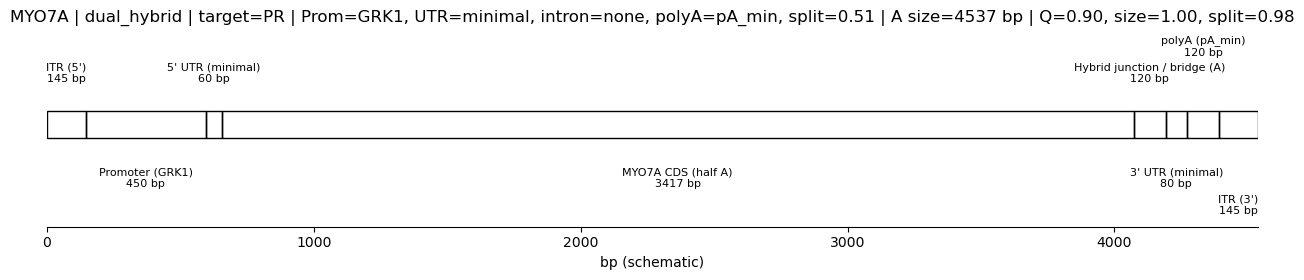

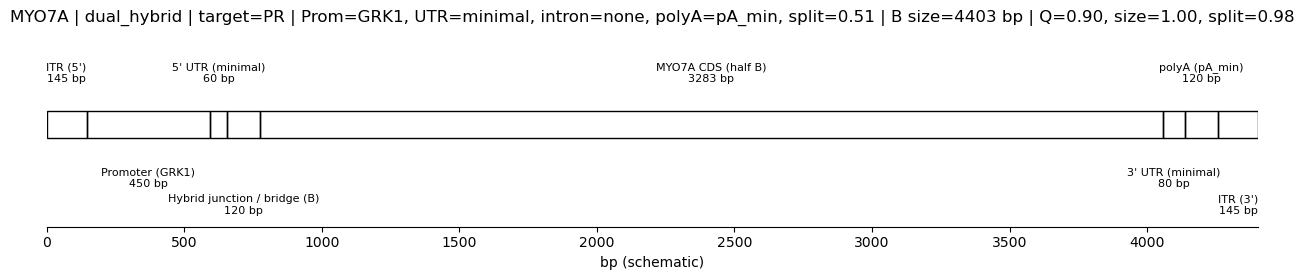

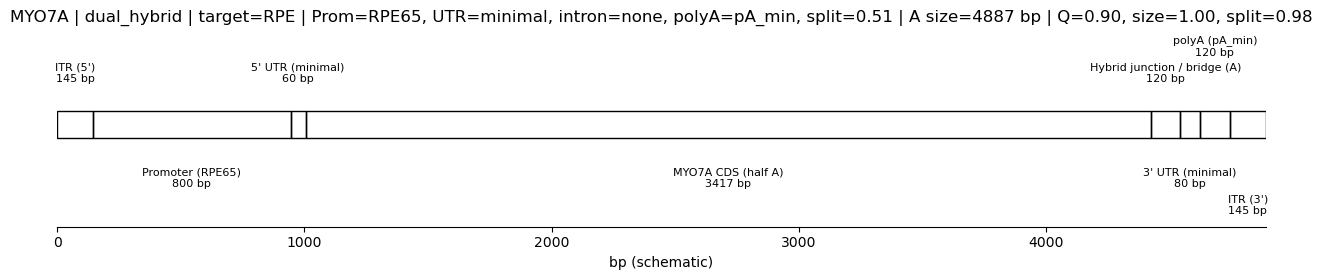

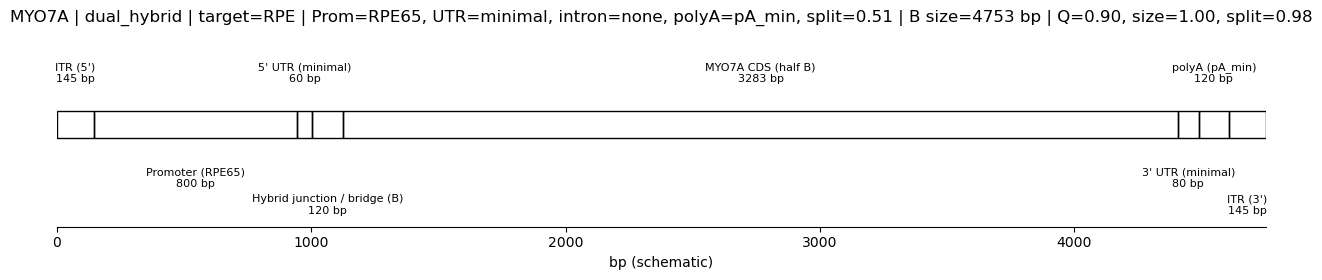

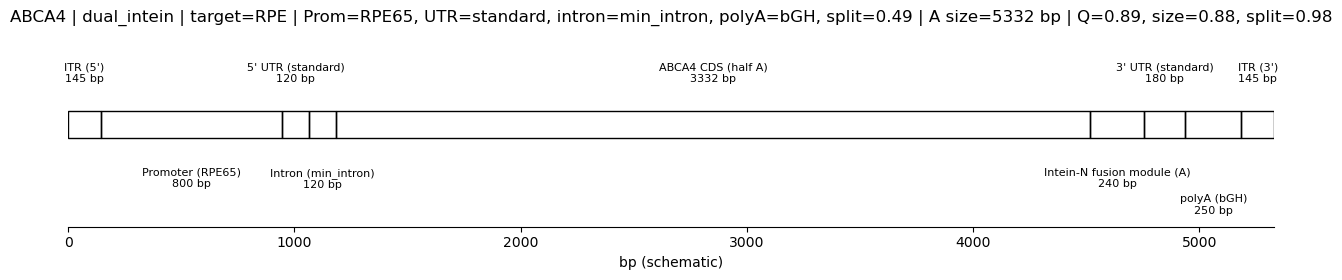

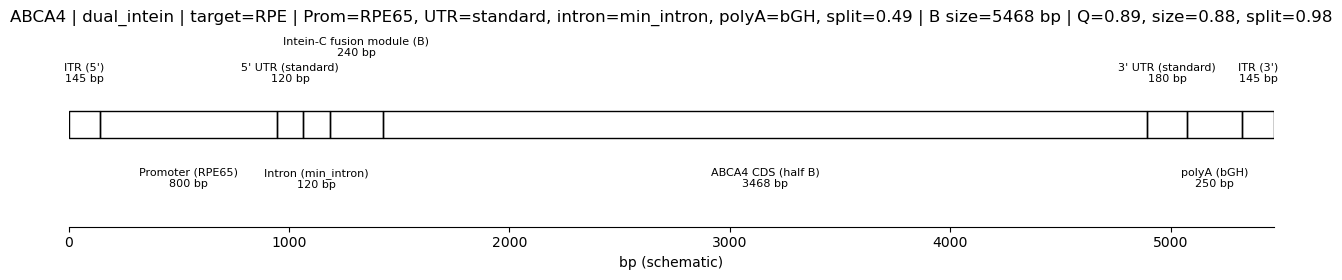

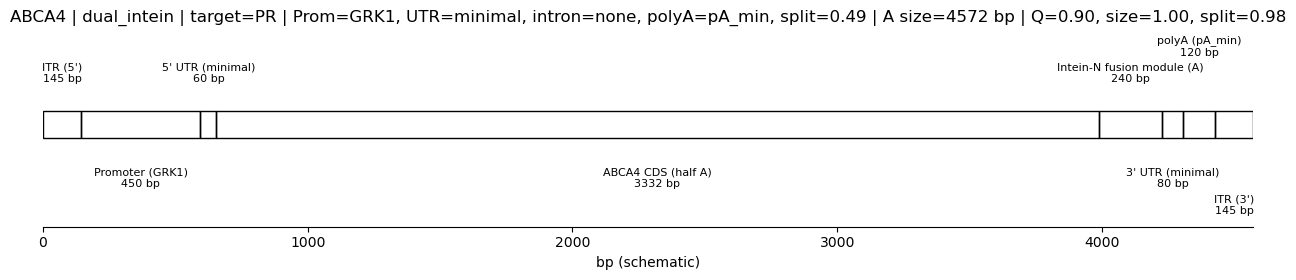

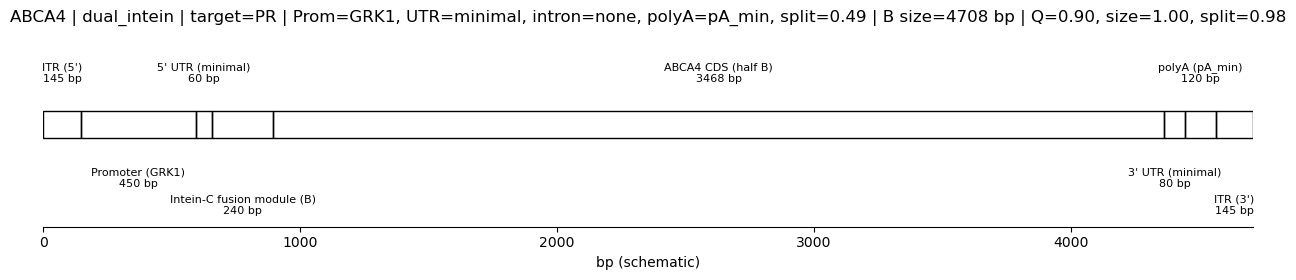

Wrote: construct_summary_v4p1.csv
Vector maps in: vector_maps_v4p1


,program_gene,target_cell,platform,promoter,utr_class,intron,polyA,split_frac,size_integrity_score,promoter_targeting_score,expression_right_sizing_score,split_balance_score,junction_fit_score,mrna_fidelity_proxy_score,manufacturability_proxy_score,innate_sensing_proxy_score,design_quality_score,vector_A_bp,vector_B_bp
0,MYO7A,PR,dual_hybrid,GRK1,minimal,none,pA_min,0.51,1.000000,0.92,0.85,0.98,0.86,0.74,0.86,0.85,0.899500,4537,4403
1,MYO7A,RPE,dual_hybrid,RPE65,minimal,none,pA_min,0.51,1.000000,0.92,0.85,0.98,0.86,0.74,0.86,0.85,0.899500,4887,4753
2,ABCA4,RPE,dual_intein,RPE65,standard,min_intron,bGH,0.49,0.878182,0.92,0.85,0.98,0.83,0.88,0.86,0.85,0.888336,5332,5468
3,ABCA4,PR,dual_intein,GRK1,minimal,none,pA_min,0.49,1.000000,0.92,0.85,0.98,0.83,0.74,0.86,0.85,0.895900,4572,4708


,program_gene,target_cell,platform,promoter,utr_class,intron,polyA,split_frac,size_integrity_score,promoter_targeting_score,expression_right_sizing_score,split_balance_score,junction_fit_score,mrna_fidelity_proxy_score,manufacturability_proxy_score,innate_sensing_proxy_score,design_quality_score,vector_A_bp,vector_B_bp
0,MYO7A,PR,dual_hybrid,GRK1,minimal,none,pA_min,0.51,1.000000,0.92,0.85,0.98,0.86,0.74,0.86,0.85,0.899500,4537,4403
1,MYO7A,RPE,dual_hybrid,RPE65,minimal,none,pA_min,0.51,1.000000,0.92,0.85,0.98,0.86,0.74,0.86,0.85,0.899500,4887,4753
2,ABCA4,RPE,dual_intein,RPE65,standard,min_intron,bGH,0.49,0.878182,0.92,0.85,0.98,0.83,0.88,0.86,0.85,0.888336,5332,5468
3,ABCA4,PR,dual_intein,GRK1,minimal,none,pA_min,0.49,1.000000,0.92,0.85,0.98,0.83,0.74,0.86,0.85,0.895900,4572,4708


In [4]:
import os
import math
from dataclasses import dataclass, asdict
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Optional notebook display
try:
    from IPython.display import display  # type: ignore
    _HAS_DISPLAY = True
except Exception:
    _HAS_DISPLAY = False


# 1) Parts library (nominal sizes, replace with exact bp if available)


ITR_BP = 145  # schematic AAV ITR length
DEFAULT_PACKAGING_SOFT_CEILING_BP = 5200  # conservative planning ceiling

PROMOTERS = {
    # Recommendation #1: cell-type enriched promoters
    "GRK1": {"bp": 450, "target": "PR", "desc": "Photoreceptor-enriched promoter"},
    "RPE65": {"bp": 800, "target": "RPE", "desc": "RPE-enriched promoter"},
    # Benchmarks (use carefully, right-sizing matters)
    "CAG": {"bp": 1700, "target": "broad", "desc": "Ubiquitous strong promoter, benchmark"},
    "CMV": {"bp": 600, "target": "broad", "desc": "Ubiquitous promoter, benchmark"},
}

UTR_CLASSES = {
    # Recommendation #2, #12: compact or tuned UTRs
    "minimal": {"bp5": 60, "bp3": 80, "desc": "Compact UTRs for size discipline"},
    "standard": {"bp5": 120, "bp3": 180, "desc": "Balanced UTRs"},
    "stability": {"bp5": 140, "bp3": 260, "desc": "Stability-biased UTRs (costs bp)"},
}

POLYA = {
    # Recommendation #13
    "pA_min": {"bp": 120, "desc": "Compact polyA"},
    "SV40": {"bp": 250, "desc": "SV40 polyA"},
    "bGH": {"bp": 250, "desc": "bGH polyA"},
}

INTRONS = {
    # Recommendation #11
    "none": {"bp": 0, "desc": "No intron"},
    "min_intron": {"bp": 120, "desc": "Minimal intron, expression support"},
}

# Recommendation #4: platform-specific junction modules (schematic)
JUNCTIONS = {
    "dual_hybrid": {
        "A": {"bp": 120, "label": "Hybrid junction / bridge (A)"},
        "B": {"bp": 120, "label": "Hybrid junction / bridge (B)"},
        "desc": "Favors DNA-level reconstitution",
    },
    "dual_trans_splicing": {
        "A": {"bp": 180, "label": "Splice donor module (A)"},
        "B": {"bp": 180, "label": "Splice acceptor module (B)"},
        "desc": "Favors mRNA-level joining",
    },
    "dual_intein": {
        "A": {"bp": 240, "label": "Intein-N fusion module (A)"},
        "B": {"bp": 240, "label": "Intein-C fusion module (B)"},
        "desc": "Favors protein-level splicing",
    },
    "single_AAV": {"desc": "Single-vector cassette"},
}

# Oversized retinal genes (nominal CDS sizes, schematic)
GENES = {
    "MYO7A": {"cds_bp": 6700, "desc": "MYO7A (USH1B) oversized CDS"},
    "ABCA4": {"cds_bp": 6800, "desc": "ABCA4 (Stargardt) oversized CDS"},
}

# 2) Data structures

@dataclass
class Segment:
    name: str
    bp: int
    kind: str

@dataclass
class VectorDesign:
    vector_name: str  # "A", "B", or "Single"
    segments: List[Segment]

    @property
    def total_bp(self) -> int:
        return int(sum(s.bp for s in self.segments))

@dataclass
class ConstructDesign:
    program_gene: str
    target_cell: str              # "RPE" or "PR"
    platform: str                 # "single_AAV" or dual platform
    promoter: str
    utr_class: str
    intron: str
    polyA: str
    split_frac: Optional[float] = None
    packaging_soft_ceiling_bp: int = DEFAULT_PACKAGING_SOFT_CEILING_BP

    vectors: Optional[List[VectorDesign]] = None
    qc: Optional[Dict[str, float]] = None

    def to_row(self) -> Dict:
        d = asdict(self)
        if self.vectors:
            d["vector_sizes_bp"] = {v.vector_name: v.total_bp for v in self.vectors}
        return d

# 3) Gene-designer QC heuristics (feature-level scores, 0..1)

def feature_qc_scores(
    gene: str,
    platform: str,
    promoter: str,
    utr_class: str,
    intron: str,
    polyA: str,
    split_frac: Optional[float],
    target_cell: str,
) -> Dict[str, float]:
    """
    Returns 0..1 "quality" scores, higher = better.

    These are schematic proxies that encode your recommendations as decision-support metrics:
    - promoter_targeting_score: #1, #14, #15
    - size_integrity_score: #2, #17, #18
    - split_balance_score: #3, #16
    - junction_fit_score: #4
    - mrna_fidelity_proxy_score: #5-8, #11-13
    - manufacturability_proxy_score: #9, #18
    - innate_sensing_proxy_score: #10
    - expression_right_sizing_score: #14
    """
    cds_bp = GENES[gene]["cds_bp"]

    # promoter targeting: initialize baseline robustly (FIX for your error)
    promoter_targeting = 0.55  # conservative default baseline

    prom_target = PROMOTERS[promoter]["target"]
    if target_cell in ("PR", "RPE"):
        if prom_target == target_cell:
            promoter_targeting = 0.92
        elif prom_target == "broad":
            promoter_targeting = 0.70
        else:
            promoter_targeting = 0.35  # mismatched cell-enriched promoter
    else:
        promoter_targeting = 0.65 if prom_target == "broad" else 0.55

    # expression right-sizing proxy (#14) 
    expression_right_sizing = 0.85
    if promoter in ("CAG", "CMV"):
        expression_right_sizing = 0.65  # risk of overexpression burden in sensitive retina lineages

    # mRNA fidelity proxy (#5-8, #11-13) 
    mrna_fidelity = 0.78
    if utr_class == "minimal":
        mrna_fidelity -= 0.04  # fewer stabilizing features, but saves size
    if intron == "min_intron":
        mrna_fidelity += 0.05  # conditional benefit
    if polyA in ("SV40", "bGH"):
        mrna_fidelity += 0.05  # robust termination
    mrna_fidelity = float(np.clip(mrna_fidelity, 0.0, 1.0))

    # manufacturability proxy (#9, #18) 
    manufacturability = 0.86
    if promoter == "CAG":
        manufacturability -= 0.06
    if utr_class == "stability":
        manufacturability -= 0.05
    manufacturability = float(np.clip(manufacturability, 0.0, 1.0))

    # innate sensing proxy (#10) 
    innate_sensing = 0.85
    if promoter == "CMV":
        innate_sensing -= 0.08
    if promoter == "CAG":
        innate_sensing -= 0.05
    innate_sensing = float(np.clip(innate_sensing, 0.0, 1.0))

    # platform/junction fit proxy (#4) 
    if platform == "single_AAV":
        junction_fit = 0.90
    elif platform == "dual_hybrid":
        junction_fit = 0.86
    elif platform == "dual_inSdual_trans_splicing" or platform == "dual_trans_splicing":
        junction_fit = 0.80
    elif platform == "dual_intein":
        junction_fit = 0.83
    else:
        junction_fit = 0.80

    # split balance (#3, #16) 
    split_balance = 1.0
    if platform != "single_AAV":
        if split_frac is None:
            split_balance = 0.0
        else:
            split_balance = float(np.clip(1.0 - 2.0 * abs(float(split_frac) - 0.5), 0.0, 1.0))
            if abs(float(split_frac) - 0.5) > 0.1:
                split_balance *= 0.85

    # size integrity (#2, #17, #18) 
    utr = UTR_CLASSES[utr_class]
    noncoding = (
        PROMOTERS[promoter]["bp"]
        + utr["bp5"]
        + utr["bp3"]
        + INTRONS[intron]["bp"]
        + POLYA[polyA]["bp"]
        + 2 * ITR_BP
    )

    soft = DEFAULT_PACKAGING_SOFT_CEILING_BP

    if platform == "single_AAV":
        est = noncoding + cds_bp
        over = max(0, est - soft)
        size_integrity = float(np.clip(1.0 - (over / 3000.0), 0.0, 1.0))
    else:
        frac = float(split_frac) if split_frac is not None else 0.5
        halfA = int(round(cds_bp * frac))
        halfB = cds_bp - halfA
        j = JUNCTIONS[platform]
        estA = noncoding + halfA + j["A"]["bp"]
        estB = noncoding + halfB + j["B"]["bp"]
        worst = max(estA, estB)
        over = max(0, worst - soft)
        size_integrity = float(np.clip(1.0 - (over / 2200.0), 0.0, 1.0))

    # overall score
    design_quality = float(np.clip(
        0.20 * size_integrity
        + 0.18 * promoter_targeting
        + 0.12 * expression_right_sizing
        + 0.14 * split_balance
        + 0.12 * junction_fit
        + 0.12 * mrna_fidelity
        + 0.07 * manufacturability
        + 0.05 * innate_sensing,
        0.0, 1.0
    ))

    return {
        "size_integrity_score": size_integrity,
        "promoter_targeting_score": promoter_targeting,
        "expression_right_sizing_score": expression_right_sizing,
        "split_balance_score": split_balance,
        "junction_fit_score": float(junction_fit),
        "mrna_fidelity_proxy_score": mrna_fidelity,
        "manufacturability_proxy_score": manufacturability,
        "innate_sensing_proxy_score": innate_sensing,
        "design_quality_score": design_quality,
    }

# 4) Recommendation-guided design choice helpers

def choose_cell_tuned_promoter(target_cell: str) -> str:
    # #1, #14, #15
    return "GRK1" if target_cell == "PR" else ("RPE65" if target_cell == "RPE" else "CAG")

def choose_size_disciplined_utr_polyA(size_pressure: bool = True) -> Tuple[str, str]:
    # #2, #12, #13
    return ("minimal", "pA_min") if size_pressure else ("standard", "bGH")

def choose_selective_intron(size_pressure: bool = True) -> str:
    # #11
    return "none" if size_pressure else "min_intron"

def choose_balanced_split(platform: str, gene: str) -> float:
    # #3, #16
    if platform == "dual_intein":
        return 0.49
    if platform == "dual_trans_splicing":
        return 0.50
    return 0.51

# 5) Construct builder (schematic parts, accurate labels)

def build_construct(design: ConstructDesign) -> ConstructDesign:
    gene = design.program_gene
    cds_bp = GENES[gene]["cds_bp"]

    promoter_bp = PROMOTERS[design.promoter]["bp"]
    utr = UTR_CLASSES[design.utr_class]
    intron_bp = INTRONS[design.intron]["bp"]
    polyA_bp = POLYA[design.polyA]["bp"]

    def head_segments() -> List[Segment]:
        segs = [
            Segment("ITR (5')", ITR_BP, "itr"),
            Segment(f"Promoter ({design.promoter})", promoter_bp, "promoter"),
            Segment(f"5' UTR ({design.utr_class})", utr["bp5"], "utr5"),
        ]
        if intron_bp > 0:
            segs.append(Segment(f"Intron ({design.intron})", intron_bp, "intron"))
        return segs

    def tail_segments() -> List[Segment]:
        return [
            Segment(f"3' UTR ({design.utr_class})", utr["bp3"], "utr3"),
            Segment(f"polyA ({design.polyA})", polyA_bp, "polyA"),
            Segment("ITR (3')", ITR_BP, "itr"),
        ]

    reg = head_segments()
    tail = tail_segments()

    vectors: List[VectorDesign] = []

    if design.platform == "single_AAV":
        segs = reg + [Segment(f"{gene} CDS (full)", cds_bp, "cds")] + tail
        vectors = [VectorDesign("Single", segs)]
    else:
        if design.split_frac is None:
            raise ValueError("Dual platforms require split_frac.")
        frac = float(design.split_frac)
        cdsA = int(round(cds_bp * frac))
        cdsB = cds_bp - cdsA

        j = JUNCTIONS[design.platform]

        segA = reg + [
            Segment(f"{gene} CDS (half A)", cdsA, "cdsA"),
            Segment(j["A"]["label"], j["A"]["bp"], "junction"),
        ] + tail

        segB = reg + [
            Segment(j["B"]["label"], j["B"]["bp"], "junction"),
            Segment(f"{gene} CDS (half B)", cdsB, "cdsB"),
        ] + tail

        vectors = [VectorDesign("A", segA), VectorDesign("B", segB)]

    design.vectors = vectors
    design.qc = feature_qc_scores(
        gene=design.program_gene,
        platform=design.platform,
        promoter=design.promoter,
        utr_class=design.utr_class,
        intron=design.intron,
        polyA=design.polyA,
        split_frac=design.split_frac,
        target_cell=design.target_cell,
    )
    return design

# 6) Visualization with non-overlapping labels

def _text_bbox_in_data(ax, txt):
    renderer = ax.figure.canvas.get_renderer()
    bb = txt.get_window_extent(renderer=renderer)
    inv = ax.transData.inverted()
    return bb.transformed(inv)

def _overlap(bb1, bb2) -> bool:
    return not (bb1.x1 < bb2.x0 or bb1.x0 > bb2.x1 or bb1.y1 < bb2.y0 or bb1.y0 > bb2.y1)

def draw_vector_map(
    vec: VectorDesign,
    title: str,
    outpath: Optional[str] = None,
    figsize=(12.5, 2.9),
    dpi: int = 300,
):
    total = vec.total_bp
    fig, ax = plt.subplots(figsize=figsize)

    y0, h = 0.0, 0.55

    # draw segments as outlined boxes (no forced colors)
    x = 0.0
    segments_xyw = []
    for s in vec.segments:
        w = max(1, int(s.bp))
        ax.add_patch(Rectangle((x, y0), w, h, fill=False, linewidth=1.0))
        segments_xyw.append((s, x, w))
        x += w

    ax.set_xlim(0, total)
    ax.set_ylim(-1.8, 2.2)
    ax.set_yticks([])
    ax.set_xlabel("bp (schematic)")
    ax.set_title(title)

    # label placement with collision avoidance
    placed = []
    for i, (s, sx, sw) in enumerate(segments_xyw):
        cx = sx + sw / 2
        y = 1.10 if (i % 2 == 0) else -0.60
        va = "bottom" if y > 0 else "top"
        label = f"{s.name}\n{int(s.bp)} bp"

        t = ax.text(cx, y, label, ha="center", va=va, fontsize=8)
        fig.canvas.draw()
        bb = _text_bbox_in_data(ax, t)

        step = 0.18
        tries = 0
        while any(_overlap(bb, other) for other in placed) and tries < 60:
            if y > 0:
                y += step
                va = "bottom"
            else:
                y -= step
                va = "top"
            t.set_position((cx, y))
            t.set_va(va)
            fig.canvas.draw()
            bb = _text_bbox_in_data(ax, t)
            tries += 1

        placed.append(bb)

    for sp in ("left", "right", "top"):
        ax.spines[sp].set_visible(False)

    plt.tight_layout()
    if outpath:
        os.makedirs(os.path.dirname(outpath), exist_ok=True)
        plt.savefig(outpath, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)


def draw_construct(design: ConstructDesign, outdir: str = "vector_maps_v4p1"):
    assert design.vectors is not None, "Build construct first."
    qc = design.qc or {}
    qc_line = f"Q={qc.get('design_quality_score', np.nan):.2f}, size={qc.get('size_integrity_score', np.nan):.2f}, split={qc.get('split_balance_score', np.nan):.2f}"

    for v in design.vectors:
        ttl = (
            f"{design.program_gene} | {design.platform} | target={design.target_cell} | "
            f"Prom={design.promoter}, UTR={design.utr_class}, intron={design.intron}, polyA={design.polyA}, "
            f"split={design.split_frac if design.split_frac is not None else 'NA'} | "
            f"{v.vector_name} size={v.total_bp} bp | {qc_line}"
        )
        outpath = os.path.join(outdir, f"{design.program_gene}_{design.platform}_{design.target_cell}_{v.vector_name}.png")
        draw_vector_map(v, ttl, outpath=outpath)

# 7) Recommended designs (integrate your recommendations into choices)

def make_recommended_designs() -> List[ConstructDesign]:
    designs: List[ConstructDesign] = []

    # MYO7A, PR, dual hybrid, strict size discipline
    platform = "dual_hybrid"
    target_cell = "PR"
    promoter = choose_cell_tuned_promoter(target_cell)
    utr_class, polyA = choose_size_disciplined_utr_polyA(size_pressure=True)
    intron = choose_selective_intron(size_pressure=True)
    split_frac = choose_balanced_split(platform, "MYO7A")
    d1 = ConstructDesign("MYO7A", target_cell, platform, promoter, utr_class, intron, polyA, split_frac=split_frac)
    designs.append(build_construct(d1))

    # MYO7A, RPE, dual hybrid, strict size discipline
    platform = "dual_hybrid"
    target_cell = "RPE"
    promoter = choose_cell_tuned_promoter(target_cell)
    utr_class, polyA = choose_size_disciplined_utr_polyA(size_pressure=True)
    intron = choose_selective_intron(size_pressure=True)
    split_frac = choose_balanced_split(platform, "MYO7A")
    d2 = ConstructDesign("MYO7A", target_cell, platform, promoter, utr_class, intron, polyA, split_frac=split_frac)
    designs.append(build_construct(d2))

    # ABCA4, RPE, dual intein, allow expression-boosting intron and robust polyA if size allows
    platform = "dual_intein"
    target_cell = "RPE"
    promoter = choose_cell_tuned_promoter(target_cell)
    utr_class, polyA = choose_size_disciplined_utr_polyA(size_pressure=False)
    intron = choose_selective_intron(size_pressure=False)
    split_frac = choose_balanced_split(platform, "ABCA4")
    d3 = ConstructDesign("ABCA4", target_cell, platform, promoter, utr_class, intron, polyA, split_frac=split_frac)
    designs.append(build_construct(d3))

    # ABCA4, PR, dual intein, strict size discipline
    platform = "dual_intein"
    target_cell = "PR"
    promoter = choose_cell_tuned_promoter(target_cell)
    utr_class, polyA = choose_size_disciplined_utr_polyA(size_pressure=True)
    intron = choose_selective_intron(size_pressure=True)
    split_frac = choose_balanced_split(platform, "ABCA4")
    d4 = ConstructDesign("ABCA4", target_cell, platform, promoter, utr_class, intron, polyA, split_frac=split_frac)
    designs.append(build_construct(d4))

    return designs

# 8) Runner: draw + export CSV summary

def run_and_export(outdir="vector_maps_v4p1", table_out="construct_summary_v4p1.csv"):
    designs = make_recommended_designs()

    for d in designs:
        draw_construct(d, outdir=outdir)

    rows = []
    for d in designs:
        row = {
            "program_gene": d.program_gene,
            "target_cell": d.target_cell,
            "platform": d.platform,
            "promoter": d.promoter,
            "utr_class": d.utr_class,
            "intron": d.intron,
            "polyA": d.polyA,
            "split_frac": d.split_frac,
        }
        if d.qc:
            row.update(d.qc)
        if d.vectors:
            for v in d.vectors:
                row[f"vector_{v.vector_name}_bp"] = v.total_bp
        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(table_out, index=False)
    print("Wrote:", table_out)
    print("Vector maps in:", outdir)

    if _HAS_DISPLAY:
        display(df)
    else:
        print(df.to_string(index=False))

    return df


# Execute
run_and_export()

# Gene Designer Proof-of-Concept (PoC)
## Goal
A self-contained, non-procedural PoC that demonstrates:

1) Construct design that anticipates failure modes:
   - capacity-aware cassette architecture
   - junction and split logic (dual-AAV)
   - sequence-level QC for transcript fidelity risks
   - expression right-sizing (therapeutic window scoring)

2) Bioinformatics-driven design QC:
   - scan and score cryptic splice motifs (donor/acceptor-like)
   - premature polyA motifs
   - unstable repeats/homopolymers
   - GC extremes
   - CpG burden
   - annotation-ready documentation

3) Decision-grade validation plans:
   - DoE matrix (promoter × platform × UTR × polyA × intron × cell context)
   - assay-to-variable mapping (WB, FACS, immunostaining, functional proxies)

4) Wet-lab execution and leadership (non-procedural):
   - generate a structured validation plan (what to measure, not how to do it)
   - per-condition assay checklists
   - downselection gates and evidence bundle outputs

## Safety note

This code generates *planning artifacts* and *in silico QC* only.
It does NOT provide experimental step-by-step protocols, volumes, timings, or conditions.

## Dependencies

pip install numpy pandas matplotlib

## Run

python gene_designer_poc.py

Outputs
-------
- outputs/constructs.csv
- outputs/qc_scores.csv
- outputs/doe_matrix.csv
- outputs/validation_plan.csv
- outputs/assay_variable_matrix.csv
- outputs/assay_checklist.csv
- outputs/figures/*.png

In [19]:
from __future__ import annotations

import os
import json
import math
import random
import re
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Repro + directories

SEED = 7
random.seed(SEED)
np.random.seed(SEED)

OUTDIR = "outputs"
FIGDIR = os.path.join(OUTDIR, "figures")
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(FIGDIR, exist_ok=True)

# 1) Configuration: design space

PROGRAMS = [
    # Oversized retinal genes (sizes here are approximations used only for relative constraint modeling)
    {"gene": "MYO7A", "cds_bp": 6700, "preferred_platforms": ["dual_hybrid", "dual_intein"]},
    {"gene": "ABCA4", "cds_bp": 6800, "preferred_platforms": ["dual_intein", "dual_hybrid"]},
]

TARGET_CELLS = ["PR", "RPE"]  # photoreceptor-like and RPE-like contexts

PROMOTERS = {
    # You can expand these; we treat them as *cell preference* + *relative strength*
    "GRK1": {"preferred_cell": "PR", "strength": 0.85, "bp": 500},
    "RPE65": {"preferred_cell": "RPE", "strength": 0.80, "bp": 650},
    "CAG": {"preferred_cell": "BROAD", "strength": 0.95, "bp": 1700},
    "CMV": {"preferred_cell": "BROAD", "strength": 0.90, "bp": 600},
}

UTR_CLASSES = {
    "minimal": {"bp": 120, "translation_bonus": 0.02, "risk_bonus": 0.00},
    "standard": {"bp": 260, "translation_bonus": 0.05, "risk_bonus": 0.01},
}

POLYA = {
    "pA_min": {"bp": 80, "stability_bonus": 0.01, "risk_bonus": 0.00},
    "bGH": {"bp": 225, "stability_bonus": 0.03, "risk_bonus": 0.00},
    "SV40": {"bp": 250, "stability_bonus": 0.03, "risk_bonus": 0.01},
}

INTRON = {
    "none": {"bp": 0, "expression_bonus": 0.00, "risk_bonus": 0.00},
    "min_intron": {"bp": 120, "expression_bonus": 0.04, "risk_bonus": 0.01},
}

PLATFORMS = {
    # Platform attributes model the efficiency ceiling of reconstitution and partial product risk
    "dual_hybrid": {"reconstitution_eff": 0.70, "partial_risk": 0.08, "junction_bp": 220},
    "dual_intein": {"reconstitution_eff": 0.75, "partial_risk": 0.07, "junction_bp": 260},
    "trans_splice": {"reconstitution_eff": 0.62, "partial_risk": 0.10, "junction_bp": 300},
}

# AAV packaging constraint (approx), used as a soft penalty model only
AAV_SOFT_CAP_BP = 5200

# 2) Assay library + mapping (non-procedural)

@dataclass(frozen=True)
class Assay:
    key: str
    name: str
    what_it_tells_you: str


def assay_library() -> Dict[str, Assay]:
    return {
        "WB_full_length": Assay(
            "WB_full_length",
            "Western blot, full-length vs truncation screen",
            "Protein integrity, relative abundance, truncation burden"
        ),
        "IF_localization": Assay(
            "IF_localization",
            "Immunostaining/confocal localization",
            "Subcellular localization and distribution in PR-like vs RPE-like context"
        ),
        "FACS_expression": Assay(
            "FACS_expression",
            "Flow cytometry, expression-positive fraction",
            "Fraction of expressing cells and relative intensity proxy"
        ),
        "Cell_health": Assay(
            "Cell_health",
            "Cell health and stress panel",
            "Viability/stress proxy to support expression right-sizing decisions"
        ),
        "Func_PR": Assay(
            "Func_PR",
            "Photoreceptor-aligned functional proxy",
            "Directionality of PR-relevant phenotype with MYO7A/ABCA4 expression"
        ),
        "Func_RPE": Assay(
            "Func_RPE",
            "RPE-aligned functional proxy",
            "Directionality of RPE-relevant phenotype (including ABCA4-related proxies)"
        ),
    }


def variable_to_assays_map() -> Dict[str, List[str]]:
    # Decision-grade mapping: each design variable must have an observable readout.
    return {
        "promoter": ["FACS_expression", "WB_full_length", "IF_localization"],
        "platform": ["WB_full_length", "IF_localization"],
        "utr_class": ["FACS_expression", "WB_full_length"],
        "polyA": ["FACS_expression", "WB_full_length"],
        "intron": ["FACS_expression", "WB_full_length"],
        "target_cell": ["IF_localization", "Func_PR", "Func_RPE"],
        "split_frac": ["WB_full_length", "FACS_expression"],
        "program_gene": ["WB_full_length", "Func_PR", "Func_RPE"],
    }

# 3) Sequence QC utilities (simple, transparent heuristics)

DNA_ALPHABET = ["A", "C", "G", "T"]


def random_dna(n: int, gc_target: float = 0.50) -> str:
    """
    Generate synthetic DNA of length n with approximate GC content.
    """
    gc_n = int(round(n * gc_target))
    at_n = n - gc_n
    seq = (["G", "C"] * (gc_n // 2) + ["G"] * (gc_n % 2) +
           ["A", "T"] * (at_n // 2) + ["A"] * (at_n % 2))
    random.shuffle(seq)
    return "".join(seq)


def gc_content(seq: str) -> float:
    if not seq:
        return 0.0
    gc = sum(1 for b in seq if b in ("G", "C"))
    return gc / len(seq)


def max_homopolymer(seq: str) -> int:
    """
    Returns the length of the longest homopolymer run (e.g., AAAAAAA).
    """
    best = 1
    run = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i - 1]:
            run += 1
            best = max(best, run)
        else:
            run = 1
    return best if seq else 0


def count_cpg(seq: str) -> int:
    return sum(1 for i in range(len(seq) - 1) if seq[i:i+2] == "CG")


def find_motifs(seq: str, motifs: List[str]) -> int:
    """
    Count occurrences of motifs in seq.
    """
    total = 0
    for m in motifs:
        total += len(re.findall(m, seq))
    return total


def cryptic_splice_risk(seq: str) -> float:
    """
    Heuristic cryptic splice risk:
    - donor-like: 'GT' in contexts (simplified)
    - acceptor-like: 'AG' in contexts (simplified)
    We intentionally keep this conservative and transparent.

    Returns a 0..1 score (higher = worse).
    """
    if not seq:
        return 0.0
    # simplified motifs:
    donor_like = len(re.findall(r"GT", seq))
    acceptor_like = len(re.findall(r"AG", seq))
    # Normalize to length
    rate = (donor_like + acceptor_like) / max(1, len(seq))
    # map to 0..1 with a soft scale
    return float(np.clip(rate * 50.0, 0.0, 1.0))


def premature_polya_risk(seq: str) -> float:
    """
    Internal polyA-like motifs (DNA version of AAUAAA is AATAAA) and variants.
    Returns 0..1 (higher = worse).
    """
    if not seq:
        return 0.0
    motifs = [r"AATAAA", r"ATTAAA", r"AAGAAA", r"AAAAAA"]
    hits = find_motifs(seq, motifs)
    rate = hits / max(1, len(seq))
    return float(np.clip(rate * 400.0, 0.0, 1.0))


def gc_extremes_risk(seq: str, window: int = 120) -> float:
    """
    Penalize extreme GC windows (too low or too high).
    Returns 0..1.
    """
    if len(seq) < window:
        g = gc_content(seq)
        extreme = max(0.0, abs(g - 0.50) - 0.15)  # tolerates 0.35..0.65
        return float(np.clip(extreme / 0.20, 0.0, 1.0))

    vals = []
    for i in range(0, len(seq) - window + 1, window):
        vals.append(gc_content(seq[i:i+window]))
    vals = np.array(vals)
    extremes = np.maximum(0.0, np.abs(vals - 0.50) - 0.15)
    score = float(np.clip(extremes.mean() / 0.20, 0.0, 1.0))
    return score


def repeat_risk(seq: str) -> float:
    """
    Penalize long homopolymers and simple repeats.
    Returns 0..1.
    """
    if not seq:
        return 0.0
    hp = max_homopolymer(seq)
    # simple dinucleotide repeat proxy
    dinuc = len(re.findall(r"(AT){6,}|(TA){6,}|(CG){6,}|(GC){6,}", seq))
    score = 0.0
    if hp >= 8:
        score += 0.6
    elif hp >= 6:
        score += 0.3
    if dinuc > 0:
        score += 0.4
    return float(np.clip(score, 0.0, 1.0))


def cpg_burden_risk(seq: str) -> float:
    """
    CpG density risk, 0..1.
    """
    if not seq:
        return 0.0
    density = count_cpg(seq) / max(1, len(seq))
    # Soft map: density ~0.02 -> moderate, ~0.04 -> high
    return float(np.clip((density - 0.01) / 0.03, 0.0, 1.0))


def sequence_qc_scores(seq: str) -> Dict[str, float]:
    """
    Returns a dictionary of QC risk components and an aggregate score.
    Higher is worse.
    """
    s1 = cryptic_splice_risk(seq)
    s2 = premature_polya_risk(seq)
    s3 = repeat_risk(seq)
    s4 = gc_extremes_risk(seq)
    s5 = cpg_burden_risk(seq)
    agg = float(np.clip(0.30*s1 + 0.25*s2 + 0.20*s3 + 0.15*s4 + 0.10*s5, 0.0, 1.0))
    return {
        "risk_cryptic_splice": s1,
        "risk_premature_polya": s2,
        "risk_repeats": s3,
        "risk_gc_extremes": s4,
        "risk_cpg_burden": s5,
        "risk_aggregate": agg,
    }

# 4) Construct + vector objects

@dataclass
class VectorHalf:
    half: str  # "A" or "B"
    estimated_bp: int
    sequence: str
    annotations: List[Tuple[str, int, int]]  # (label, start, end)


@dataclass
class Construct:
    construct_id: str
    program_gene: str
    target_cell: str
    promoter: str
    platform: str
    utr_class: str
    polyA: str
    intron: str
    split_frac: float  # fraction of CDS in half A
    estimated_full_cassette_bp: int
    limiting_half_bp: int
    packaging_penalty: float  # 0..1
    qc: Dict[str, float]
    predicted_expression: float  # 0..1
    predicted_stress: float  # 0..1
    therapeutic_window_score: float  # 0..1 (higher better)
    vectors: List[VectorHalf]


def estimate_packaging_penalty(limiting_half_bp: int) -> float:
    """
    Soft penalty:
    - near cap: small penalty
    - above cap: grows quickly toward 1
    """
    if limiting_half_bp <= AAV_SOFT_CAP_BP:
        # mild penalty as you approach the cap
        frac = limiting_half_bp / AAV_SOFT_CAP_BP
        return float(np.clip((frac - 0.85) / 0.15, 0.0, 0.25))
    # above cap, stronger penalty
    over = limiting_half_bp - AAV_SOFT_CAP_BP
    return float(np.clip(0.25 + over / 1200.0, 0.25, 1.0))


def promoter_target_score(promoter: str, target_cell: str) -> float:
    meta = PROMOTERS[promoter]
    pref = meta["preferred_cell"]
    if pref == "BROAD":
        return 0.70
    return 0.90 if pref == target_cell else 0.45


def build_synthetic_cds(gene: str, cds_bp: int) -> str:
    """
    Synthetic CDS-like sequence (placeholder) for QC demonstration.
    We can optionally seed a few risk motifs to show QC discrimination.
    """
    base_gc = 0.55 if gene == "ABCA4" else 0.52
    seq = random_dna(cds_bp, gc_target=base_gc)

    # Inject a small number of problematic motifs with low probability
    # to simulate real-world liabilities.
    if random.random() < 0.35:
        # add an internal polyA-like signal somewhere
        pos = random.randint(200, max(201, cds_bp - 10))
        seq = seq[:pos] + "AATAAA" + seq[pos+6:]
    if random.random() < 0.25:
        # add a homopolymer
        pos = random.randint(200, max(201, cds_bp - 12))
        seq = seq[:pos] + "AAAAAAAAAA" + seq[pos+10:]
    return seq


def make_half_sequences(full_cds: str, split_frac: float, platform: str) -> Tuple[str, str, int]:
    """
    Returns (cdsA, cdsB, junction_bp).
    """
    cds_len = len(full_cds)
    cut = int(round(cds_len * split_frac))
    cut = int(np.clip(cut, 800, cds_len - 800))  # avoid extreme splits

    cdsA = full_cds[:cut]
    cdsB = full_cds[cut:]

    junction_bp = PLATFORMS[platform]["junction_bp"]
    return cdsA, cdsB, junction_bp


def estimate_cassette_bp(promoter: str, utr_class: str, polyA: str, intron: str, cds_half_bp: int, junction_bp: int) -> int:
    """
    Estimate half-vector cassette size as promoter + UTR + (optional intron) + CDS_half + junction module + polyA
    """
    return (
        PROMOTERS[promoter]["bp"] +
        UTR_CLASSES[utr_class]["bp"] +
        INTRON[intron]["bp"] +
        cds_half_bp +
        junction_bp +
        POLYA[polyA]["bp"]
    )


def predict_expression(
    promoter: str,
    target_cell: str,
    platform: str,
    utr_class: str,
    polyA: str,
    intron: str,
    packaging_penalty: float,
    qc_risk_agg: float,
    split_balance_penalty: float,
) -> float:
    """
    Transparent heuristic predictor, returns 0..1.
    Interpretable composition:
    - promoter strength × targeting
    - platform reconstitution efficiency
    - modest bonuses from UTR/polyA/intron
    - penalties from packaging, QC risk, split imbalance
    """
    prom_strength = PROMOTERS[promoter]["strength"]
    targeting = promoter_target_score(promoter, target_cell)

    platform_eff = PLATFORMS[platform]["reconstitution_eff"]
    reg_bonus = (
        UTR_CLASSES[utr_class]["translation_bonus"] +
        POLYA[polyA]["stability_bonus"] +
        INTRON[intron]["expression_bonus"]
    )

    # penalties
    pen = 0.60*packaging_penalty + 0.45*qc_risk_agg + 0.35*split_balance_penalty

    raw = (prom_strength * targeting * platform_eff) + reg_bonus - pen
    return float(np.clip(raw, 0.0, 1.0))


def predict_stress(
    promoter: str,
    target_cell: str,
    predicted_expression: float,
    qc_risk_agg: float,
    platform: str
) -> float:
    """
    Stress proxy: rises with expression beyond a moderate band, and with sequence risks.
    This encodes "expression right-sizing" logic.
    """
    # expression-driven stress is low near ~0.45, higher when very high
    expr_peak = 0.45
    expr_term = abs(predicted_expression - expr_peak) / 0.55  # 0..~1
    expr_term = float(np.clip(expr_term, 0.0, 1.0))

    # platform partial product risk contributes
    partial = PLATFORMS[platform]["partial_risk"]

    # broad promoters in the "wrong" cell context can add burden (simple proxy)
    mismatch = 0.0
    pref = PROMOTERS[promoter]["preferred_cell"]
    if pref in ("PR", "RPE") and pref != target_cell:
        mismatch = 0.15
    if pref == "BROAD":
        mismatch = 0.08

    stress = 0.45*expr_term + 0.35*qc_risk_agg + 0.20*partial + mismatch
    return float(np.clip(stress, 0.0, 1.0))


def therapeutic_window_score(predicted_expression: float, predicted_stress: float) -> float:
    """
    Higher is better.
    Encourage expression in a 'therapeutic window' while penalizing stress.
    """
    # Expression window: prefer 0.35..0.60 (broad), center ~0.48
    center = 0.48
    expr_score = 1.0 - (abs(predicted_expression - center) / 0.48)
    expr_score = float(np.clip(expr_score, 0.0, 1.0))
    score = 0.65*expr_score + 0.35*(1.0 - predicted_stress)
    return float(np.clip(score, 0.0, 1.0))


def split_balance_penalty(split_frac: float) -> float:
    """
    Penalize imbalance away from 0.5.
    """
    return float(np.clip(abs(split_frac - 0.50) / 0.20, 0.0, 1.0))


def annotate_half(promoter: str, utr_class: str, intron: str, polyA: str, half_label: str,
                  seq: str, junction_bp: int, cds_len: int) -> List[Tuple[str, int, int]]:
    """
    Provide simple annotations to support vector maps and documentation.
    Coordinates are on the synthetic half sequence string.
    """
    # We simulate an "assembled half" with segments in order.
    p_bp = PROMOTERS[promoter]["bp"]
    u_bp = UTR_CLASSES[utr_class]["bp"]
    i_bp = INTRON[intron]["bp"]
    j_bp = junction_bp
    pa_bp = POLYA[polyA]["bp"]

    # Synthetic assembly: promoter + UTR + intron + CDS + junction + polyA
    # Here, seq already represents the CDS half. We'll report coordinates relative to the assembled half.
    start = 0
    ann = []
    ann.append(("Promoter:" + promoter, start, start + p_bp)); start += p_bp
    ann.append(("UTR:" + utr_class, start, start + u_bp)); start += u_bp
    if i_bp > 0:
        ann.append(("Intron:" + intron, start, start + i_bp)); start += i_bp
    ann.append((f"CDS_half:{half_label}", start, start + cds_len)); start += cds_len
    ann.append(("JunctionModule", start, start + j_bp)); start += j_bp
    ann.append(("polyA:" + polyA, start, start + pa_bp)); start += pa_bp
    return ann


def build_construct(
    gene: str,
    cds_bp: int,
    target_cell: str,
    promoter: str,
    platform: str,
    utr_class: str,
    polyA: str,
    intron: str,
    split_frac: float,
) -> Construct:
    full_cds = build_synthetic_cds(gene, cds_bp)
    cdsA, cdsB, junction_bp = make_half_sequences(full_cds, split_frac, platform)

    # Estimate half sizes
    halfA_bp = estimate_cassette_bp(promoter, utr_class, polyA, intron, len(cdsA), junction_bp)
    halfB_bp = estimate_cassette_bp(promoter, utr_class, polyA, intron, len(cdsB), junction_bp)
    limiting_half = max(halfA_bp, halfB_bp)
    pack_pen = estimate_packaging_penalty(limiting_half)

    # Sequence QC on the "coding halves" (plus we could include junction modules, here simplified)
    qcA = sequence_qc_scores(cdsA)
    qcB = sequence_qc_scores(cdsB)
    qc_agg = float(np.clip(0.5*qcA["risk_aggregate"] + 0.5*qcB["risk_aggregate"], 0.0, 1.0))

    sb_pen = split_balance_penalty(split_frac)

    pred_expr = predict_expression(
        promoter=promoter,
        target_cell=target_cell,
        platform=platform,
        utr_class=utr_class,
        polyA=polyA,
        intron=intron,
        packaging_penalty=pack_pen,
        qc_risk_agg=qc_agg,
        split_balance_penalty=sb_pen,
    )
    pred_stress = predict_stress(promoter, target_cell, pred_expr, qc_agg, platform)
    tw_score = therapeutic_window_score(pred_expr, pred_stress)

    # Build synthetic "assembled half sequences" for documentation (not biologically exact)
    def assemble_half(cds_half: str) -> str:
        return (
            random_dna(PROMOTERS[promoter]["bp"], gc_target=0.50) +
            random_dna(UTR_CLASSES[utr_class]["bp"], gc_target=0.45) +
            (random_dna(INTRON[intron]["bp"], gc_target=0.40) if INTRON[intron]["bp"] > 0 else "") +
            cds_half +
            random_dna(junction_bp, gc_target=0.50) +
            random_dna(POLYA[polyA]["bp"], gc_target=0.35)
        )

    halfA_seq = assemble_half(cdsA)
    halfB_seq = assemble_half(cdsB)

    annA = annotate_half(promoter, utr_class, intron, polyA, "A", halfA_seq, junction_bp, len(cdsA))
    annB = annotate_half(promoter, utr_class, intron, polyA, "B", halfB_seq, junction_bp, len(cdsB))

    vA = VectorHalf("A", halfA_bp, halfA_seq, annA)
    vB = VectorHalf("B", halfB_bp, halfB_seq, annB)

    cid = f"{gene}_{target_cell}_{platform}_{promoter}_{utr_class}_{polyA}_{intron}_sf{split_frac:.2f}"

    qc = {
        "qcA_risk_aggregate": qcA["risk_aggregate"],
        "qcB_risk_aggregate": qcB["risk_aggregate"],
        "qc_risk_aggregate": qc_agg,
        **{k: qc_agg for k in []}  # placeholder if you want to add derived metrics
    }
    # Keep detailed QC components too (mean of halves)
    for k in ["risk_cryptic_splice", "risk_premature_polya", "risk_repeats", "risk_gc_extremes", "risk_cpg_burden"]:
        qc[k] = float(np.clip(0.5*qcA[k] + 0.5*qcB[k], 0.0, 1.0))

    return Construct(
        construct_id=cid,
        program_gene=gene,
        target_cell=target_cell,
        promoter=promoter,
        platform=platform,
        utr_class=utr_class,
        polyA=polyA,
        intron=intron,
        split_frac=float(split_frac),
        estimated_full_cassette_bp=int(halfA_bp + halfB_bp),
        limiting_half_bp=int(limiting_half),
        packaging_penalty=float(pack_pen),
        qc=qc,
        predicted_expression=float(pred_expr),
        predicted_stress=float(pred_stress),
        therapeutic_window_score=float(tw_score),
        vectors=[vA, vB],
    )

# 5) DoE matrix + validation plan

def generate_doe_matrix() -> pd.DataFrame:
    """
    DoE: promoter × platform × UTR × polyA × intron × target_cell × program_gene
    Keep it reasonable by restricting promoter to cell-appropriate set per cell.
    """
    rows = []
    for p in PROGRAMS:
        gene = p["gene"]
        for cell in TARGET_CELLS:
            # promoter candidates per cell
            prom_candidates = ["GRK1", "CAG"] if cell == "PR" else ["RPE65", "CAG"]
            # also include CMV as a benchmark occasionally
            prom_candidates = prom_candidates + ["CMV"]

            for platform in p["preferred_platforms"]:
                for promoter in prom_candidates:
                    for utr in UTR_CLASSES.keys():
                        for pa in POLYA.keys():
                            for intr in INTRON.keys():
                                rows.append({
                                    "program_gene": gene,
                                    "target_cell": cell,
                                    "platform": platform,
                                    "promoter": promoter,
                                    "utr_class": utr,
                                    "polyA": pa,
                                    "intron": intr,
                                })
    df = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)
    df["condition_id"] = ["COND_%04d" % i for i in range(1, len(df) + 1)]
    return df


def attach_split_choices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add split_frac choices around balanced splits.
    """
    # Small panel of candidate splits for balancing
    splits = [0.48, 0.50, 0.52]
    out = []
    for _, r in df.iterrows():
        for sf in splits:
            rr = dict(r)
            rr["split_frac"] = sf
            rr["condition_id"] = f"{r['condition_id']}_sf{sf:.2f}"
            out.append(rr)
    return pd.DataFrame(out)


def build_validation_plan(doe_df: pd.DataFrame) -> pd.DataFrame:
    """
    Produce a decision-grade validation plan:
    - map variables to assays
    - define downselection gates (non-procedural)
    """
    vmap = variable_to_assays_map()

    def assays_for_row(row) -> List[str]:
        assays = set()
        # Always confirm integrity + localization + health
        assays.update(["WB_full_length", "IF_localization", "Cell_health"])

        # FACS is informative especially for promoter/UTR/polyA/intron comparisons
        assays.add("FACS_expression")

        # functional proxies depend on cell context
        if row["target_cell"] == "PR":
            assays.add("Func_PR")
        else:
            assays.add("Func_RPE")

        return sorted(assays)

    plan = doe_df.copy()
    plan["assays"] = plan.apply(lambda r: "; ".join(assays_for_row(r)), axis=1)

    # Downselection gates: what evidence is required (not a protocol)
    plan["gate_1_integrity"] = "Full-length protein dominates over truncation signal"
    plan["gate_2_localization"] = "Localization consistent with intended retinal lineage"
    plan["gate_3_function"] = "Functional proxy improves in correct direction vs controls"
    plan["gate_4_stress"] = "Acceptable health/stress profile at effective expression"
    plan["gate_5_developability"] = "Limiting half near/below practical size budget, low QC risk"

    return plan


def make_assay_variable_matrix() -> pd.DataFrame:
    lib = assay_library()
    vmap = variable_to_assays_map()

    assay_keys = list(lib.keys())
    variables = ["promoter", "platform", "utr_class", "polyA", "intron", "target_cell", "split_frac", "program_gene"]

    rows = []
    for a in assay_keys:
        row = {"assay_key": a, "assay_name": lib[a].name}
        for v in variables:
            row[v] = 1 if a in vmap.get(v, []) else 0
        rows.append(row)
    return pd.DataFrame(rows)


def make_assay_checklist(plan_df: pd.DataFrame) -> pd.DataFrame:
    """
    One row per (condition × assay) for tracking completion and linking results files.
    """
    items = []
    for _, r in plan_df.iterrows():
        assays = [a.strip() for a in str(r["assays"]).split(";") if a.strip()]
        for a in assays:
            items.append({
                "condition_id": r["condition_id"],
                "program_gene": r["program_gene"],
                "target_cell": r["target_cell"],
                "assay": a,
                "status": "planned",
                "results_file": "",
                "notes": "",
            })
    return pd.DataFrame(items)

# 6) Plotting utilities

def plot_size_vs_expression(df: pd.DataFrame, fname: str):
    plt.figure(figsize=(7.2, 4.8))
    plt.scatter(df["limiting_half_bp"], df["predicted_expression"])
    plt.axvline(AAV_SOFT_CAP_BP, linestyle="--")
    plt.xlabel("Limiting half cassette size (bp, estimated)")
    plt.ylabel("Predicted full-length expression (0–1)")
    plt.title("Capacity pressure vs predicted expression")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, fname), dpi=300)
    plt.close()


def plot_risk_vs_expression(df: pd.DataFrame, fname: str):
    plt.figure(figsize=(7.2, 4.8))
    plt.scatter(df["qc_risk_aggregate"], df["predicted_expression"])
    plt.xlabel("Aggregate sequence risk (0–1)")
    plt.ylabel("Predicted full-length expression (0–1)")
    plt.title("Sequence risk vs predicted expression")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, fname), dpi=300)
    plt.close()


def plot_therapeutic_window(df: pd.DataFrame, fname: str):
    plt.figure(figsize=(7.2, 4.8))
    plt.scatter(df["predicted_expression"], df["predicted_stress"])
    plt.xlabel("Predicted expression (0–1)")
    plt.ylabel("Predicted stress proxy (0–1)")
    plt.title("Expression right-sizing, expression vs stress")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, fname), dpi=300)
    plt.close()


def plot_top_constructs_bar(df: pd.DataFrame, fname: str, n: int = 15):
    top = df.sort_values("therapeutic_window_score", ascending=False).head(n).copy()
    # shorten labels
    top["label"] = top["construct_id"].str.replace("dual_", "d_", regex=False).str.replace("standard", "std", regex=False)
    plt.figure(figsize=(9.0, 5.2))
    plt.barh(top["label"][::-1], top["therapeutic_window_score"][::-1])
    plt.xlabel("Therapeutic-window score (higher better)")
    plt.title(f"Top {n} constructs by therapeutic-window score")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, fname), dpi=300)
    plt.close()

# 7) Main driver: fast iteration loop

def run_poc():
    # 1) DoE and plan
    doe = generate_doe_matrix()
    doe = attach_split_choices(doe)
    plan = build_validation_plan(doe)

    # 2) Build constructs and score
    constructs: List[Construct] = []
    for p in PROGRAMS:
        gene = p["gene"]
        cds_bp = p["cds_bp"]
        sub = doe[doe["program_gene"] == gene].copy()

        for _, r in sub.iterrows():
            c = build_construct(
                gene=gene,
                cds_bp=cds_bp,
                target_cell=r["target_cell"],
                promoter=r["promoter"],
                platform=r["platform"],
                utr_class=r["utr_class"],
                polyA=r["polyA"],
                intron=r["intron"],
                split_frac=float(r["split_frac"]),
            )
            constructs.append(c)

    # 3) Export tables
    df_constructs = pd.DataFrame([{
        **{k: getattr(c, k) for k in [
            "construct_id", "program_gene", "target_cell", "promoter", "platform",
            "utr_class", "polyA", "intron", "split_frac",
            "estimated_full_cassette_bp", "limiting_half_bp",
            "packaging_penalty", "predicted_expression", "predicted_stress",
            "therapeutic_window_score"
        ]},
        # flatten QC
        "qc_risk_aggregate": c.qc["qc_risk_aggregate"],
        "risk_cryptic_splice": c.qc["risk_cryptic_splice"],
        "risk_premature_polya": c.qc["risk_premature_polya"],
        "risk_repeats": c.qc["risk_repeats"],
        "risk_gc_extremes": c.qc["risk_gc_extremes"],
        "risk_cpg_burden": c.qc["risk_cpg_burden"],
    } for c in constructs])

    df_constructs.to_csv(os.path.join(OUTDIR, "constructs.csv"), index=False)

    # QC breakdown table
    df_qc = df_constructs[[
        "construct_id", "program_gene", "target_cell",
        "qc_risk_aggregate", "risk_cryptic_splice", "risk_premature_polya",
        "risk_repeats", "risk_gc_extremes", "risk_cpg_burden",
        "packaging_penalty"
    ]].copy()
    df_qc.to_csv(os.path.join(OUTDIR, "qc_scores.csv"), index=False)

    # DoE and plan exports
    doe.to_csv(os.path.join(OUTDIR, "doe_matrix.csv"), index=False)
    plan.to_csv(os.path.join(OUTDIR, "validation_plan.csv"), index=False)

    # assay-variable matrix and checklist
    avm = make_assay_variable_matrix()
    avm.to_csv(os.path.join(OUTDIR, "assay_variable_matrix.csv"), index=False)
    checklist = make_assay_checklist(plan)
    checklist.to_csv(os.path.join(OUTDIR, "assay_checklist.csv"), index=False)

    # 4) Figures (publishable-style: no fixed colors)
    plot_size_vs_expression(df_constructs, "fig1_size_vs_expression.png")
    plot_risk_vs_expression(df_constructs, "fig2_risk_vs_expression.png")
    plot_therapeutic_window(df_constructs, "fig3_expression_vs_stress.png")
    plot_top_constructs_bar(df_constructs, "fig4_top_constructs.png")
    
    # 5) Create a compact manifest for start-up style reporting
    manifest = {
        "outputs": {
            "constructs": "constructs.csv",
            "qc_scores": "qc_scores.csv",
            "doe_matrix": "doe_matrix.csv",
            "validation_plan": "validation_plan.csv",
            "assay_variable_matrix": "assay_variable_matrix.csv",
            "assay_checklist": "assay_checklist.csv",
        },
        "figures": [
            "figures/fig1_size_vs_expression.png",
            "figures/fig2_risk_vs_expression.png",
            "figures/fig3_expression_vs_stress.png",
            "figures/fig4_top_constructs.png",
        ],
        "decision_logic": {
            "purpose": "Fast iteration triage of construct panel designs under capacity + fidelity constraints",
            "downselection_gates": [
                "Full-length protein integrity dominates over truncations",
                "Localization consistent with target cell context",
                "Functional proxy improves in correct direction",
                "Acceptable stress/viability relative to effect",
                "Developability: limiting half within size budget + low QC risk",
            ],
        }
    }
    with open(os.path.join(OUTDIR, "manifest.json"), "w") as f:
        json.dump(manifest, f, indent=2)

    # 6) Print a concise, executive summary
    top = df_constructs.sort_values("therapeutic_window_score", ascending=False).head(10)
    print("PoC complete. Key files written to:", OUTDIR)
    print("Top 10 constructs by therapeutic-window score:")
    print(top[[
        "construct_id", "program_gene", "target_cell", "platform", "promoter",
        "limiting_half_bp", "packaging_penalty", "qc_risk_aggregate",
        "predicted_expression", "predicted_stress", "therapeutic_window_score"
    ]].to_string(index=False))
    return top
    
if __name__ == "__main__":
    run_poc()

PoC complete. Key files written to: outputs
Top 10 constructs by therapeutic-window score:
                                              construct_id program_gene target_cell    platform promoter  limiting_half_bp  packaging_penalty  qc_risk_aggregate  predicted_expression  predicted_stress  therapeutic_window_score
      ABCA4_PR_dual_intein_GRK1_minimal_pA_min_none_sf0.50        ABCA4          PR dual_intein     GRK1              4360           0.000000           0.474706              0.390132          0.229130                  0.798109
     MYO7A_PR_dual_intein_GRK1_standard_pA_min_none_sf0.50        MYO7A          PR dual_intein     GRK1              4450           0.038462           0.519701              0.376807          0.255780                  0.770737
MYO7A_PR_dual_intein_GRK1_minimal_pA_min_min_intron_sf0.50        MYO7A          PR dual_intein     GRK1              4430           0.012821           0.579552              0.375259          0.277995                  0.760865
 